In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN  # 聚类
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 模型评估/矩阵/分数
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder # 数据规范,极大极小值,标准化,标签转化

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC # 支持向量机分类器算法
from sklearn.compose import ColumnTransformer # 列转化
from sklearn.tree import DecisionTreeClassifier #决策树
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis   # 线性分类
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # 随机森林
from sklearn.naive_bayes import GaussianNB # 贝叶斯
from sklearn.neighbors import KNeighborsClassifier # K近邻算法
from sklearn.pipeline import Pipeline # 整合数据预处理步骤
from sklearn.model_selection import GridSearchCV # 模型调优,系统地遍历多种参数组合
from sklearn.neural_network import MLPClassifier #神经网络
from sklearn import metrics # 评估分类,聚类的效果
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 # 卡方检验

from scipy.spatial.distance import cdist # 聚类效果检验
from pandas.tseries.offsets import Day
import collections
import time
import warnings

%matplotlib inline
warnings.filterwarnings('ignore') # 忽略错误

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'Microsoft YaHei' # 显示汉字
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.float_format', '{:14f}'.format)  # 显示数字时不采取科学计数法，而是完整显示。

# 数据来源
https://www.kaggle.com/datasets/qamaruddinkhichi/pakistan-largest-e-commerce-dataset

分析任务:  
1.探索分析  
2.用户分层  
3.关联推荐  
4.建模预测(复购、取消订单、退款订单)  


# 结论:  
1.16~18年间，平台共产生58万笔订单。通过分析得知订单状态分布存在问题，其中订单取消率达34.4%.订单退款率达11.6%。平均每年退款金额占平台流水的56.49%左右，退款金额占平台流水的11.37%左右。
为了降低这些订单的影响，能提前发现问题订单。提取特征建模，对取消订单、退款订单进行预测。  
取消订单的预测准确率约81%左右，判断为可能取消的订单准确率达80%。  
退款的预测准确率约86.5%，判断为取消的订单准确率50%。  
此外，有推荐人的订单质量较高，取消和退款的比例比无推荐人的更低。  

2.在平台用户方面,从平台创建到数据截至时间，一共115335名注册用户。其中62249名用户仅一次复购， 53086名用户有1次以上的复购。在有复购的用户中，平均复购时间是10天。用户复购的周期比较长，而且复购人数没达到50%。针对用户是否会复购提取特征进行预测。模型准确率60%。判断为不会复购的准确率约85%。  
通过对用户使用RFM模型分层，以及记录每名用户从注册至今的活跃标签，发现在活跃程度上，近一个月有购买记录的用户仅5968人。每月无购买的沉睡用户和最少一次购买的正常用户基本持平。  
根据用户的历史购买记录。统计、整理商品的相似推荐。通过随机20次抽取100名用户的订单来检验推荐效果。发现有推荐的商品约有20%左右会出现在用户之后的订单中。说明推荐具有一定效果。  

3.从平台的销量分布来看，不同SKU的销量不平衡。几乎成直角分布。

## 查看数据和数据预处理

In [2]:
df = pd.read_csv('Pakistan Largest Ecommerce Dataset.csv')

In [3]:
for i in df.columns:
    print('-'*20+i+'-'*20)
    print(df[i].value_counts())
    

--------------------item_id--------------------
211131.000000    1
683031.000000    1
683022.000000    1
683023.000000    1
683030.000000    1
                ..
456081.000000    1
456080.000000    1
456079.000000    1
456078.000000    1
905208.000000    1
Name: item_id, Length: 584524, dtype: int64
--------------------status--------------------
complete          233685
canceled          201249
received           77290
order_refunded     59529
refund              8050
cod                 2859
paid                1159
closed               494
payment_review        57
pending               48
processing            33
holded                31
fraud                 10
pending_paypal         7
exchange               4
\N                     4
Name: status, dtype: int64
--------------------created_at--------------------
11/25/2016    15169
11/17/2017    13698
11/24/2017    13191
5/19/2017     11511
11/23/2016     8478
              ...  
8/22/2018        92
9/14/2016        83
7/6/2016      

In [4]:
df.drop(columns=[ 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'],inplace=True,axis=1)

In [5]:
df.columns

Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', ' MV ', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID'],
      dtype='object')

In [6]:
df.columns = [
    '商品编号', '订单状态', '创建时间', 'SKU', '价格', '购买数量', '订单总额', '订单编号', '商品分类',
    '销售佣金代码', '折扣金额', '支付方式', '订单处理日期', 'BI状态', '市场价值', '年份', '月份',
    '客户注册时间', '月份和年份', '财年', '客户编号'
]

In [7]:
for i in df.columns:
    print('-'*20+i+'-'*20)
    print(df[i].value_counts())
    print()
    print('标签数量:',df[i].nunique())
    print('列长度:',df[i].count())
    print()

--------------------商品编号--------------------
211131.000000    1
683031.000000    1
683022.000000    1
683023.000000    1
683030.000000    1
                ..
456081.000000    1
456080.000000    1
456079.000000    1
456078.000000    1
905208.000000    1
Name: 商品编号, Length: 584524, dtype: int64

标签数量: 584524
列长度: 584524

--------------------订单状态--------------------
complete          233685
canceled          201249
received           77290
order_refunded     59529
refund              8050
cod                 2859
paid                1159
closed               494
payment_review        57
pending               48
processing            33
holded                31
fraud                 10
pending_paypal         7
exchange               4
\N                     4
Name: 订单状态, dtype: int64

标签数量: 16
列长度: 584509

--------------------创建时间--------------------
11/25/2016    15169
11/17/2017    13698
11/24/2017    13191
5/19/2017     11511
11/23/2016     8478
              ...  
8/22/2018        92


In [8]:
df.replace({f'\\N':'no','#REF!':np.nan},inplace =True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   商品编号    584524 non-null  float64
 1   订单状态    584509 non-null  object 
 2   创建时间    584524 non-null  object 
 3   SKU     584504 non-null  object 
 4   价格      584524 non-null  float64
 5   购买数量    584524 non-null  float64
 6   订单总额    584524 non-null  float64
 7   订单编号    584524 non-null  object 
 8   商品分类    584360 non-null  object 
 9   销售佣金代码  447349 non-null  object 
 10  折扣金额    584524 non-null  float64
 11  支付方式    584524 non-null  object 
 12  订单处理日期  584524 non-null  object 
 13  BI状态    584523 non-null  object 
 14  市场价值    584524 non-null  object 
 15  年份      584524 non-null  float64
 16  月份      584524 non-null  float64
 17  客户注册时间  584513 non-null  object 
 18  月份和年份   584524 non-null  object 
 19  财年      584524 non-null  object 
 20  客户编号    584513 non-null  float64
dtypes: float

In [10]:
# 
df.dropna(how='all',inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584524 entries, 0 to 584523
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   商品编号    584524 non-null  float64
 1   订单状态    584509 non-null  object 
 2   创建时间    584524 non-null  object 
 3   SKU     584504 non-null  object 
 4   价格      584524 non-null  float64
 5   购买数量    584524 non-null  float64
 6   订单总额    584524 non-null  float64
 7   订单编号    584524 non-null  object 
 8   商品分类    584360 non-null  object 
 9   销售佣金代码  447349 non-null  object 
 10  折扣金额    584524 non-null  float64
 11  支付方式    584524 non-null  object 
 12  订单处理日期  584524 non-null  object 
 13  BI状态    584523 non-null  object 
 14  市场价值    584524 non-null  object 
 15  年份      584524 non-null  float64
 16  月份      584524 non-null  float64
 17  客户注册时间  584513 non-null  object 
 18  月份和年份   584524 non-null  object 
 19  财年      584524 non-null  object 
 20  客户编号    584513 non-null  float64
dtypes: float64

In [12]:
# 检查有空值的列
a = [i for i in df.columns if df[i].count() !=584524]
print(a)

['订单状态', 'SKU', '商品分类', '销售佣金代码', 'BI状态', '客户注册时间', '客户编号']


In [13]:
df[df['订单状态'].isna()]
# 分类变量,众数填补
df['订单状态'].fillna(df['订单状态'].mode()[0],inplace = True)

In [14]:
df[df['SKU'].isna()]
df['SKU'].fillna(df['SKU'].mode()[0],inplace = True)
# 同上,众数补充

In [15]:
df[df['商品分类'].isna()]
df['商品分类'].fillna(df['商品分类'].mode()[0],inplace = True)
# 同上,众数补充

In [16]:
df[df['销售佣金代码'].isna()]
df['销售佣金代码'].fillna('no',inplace = True)
# 缺失较多,新建一类

In [17]:
df[df['客户注册时间'].isna()]
# 体量小,按用户首笔订单填充
df['客户注册时间'].fillna(df['创建时间'],inplace = True)

In [18]:
df[df['客户编号'].isna()]
# 体量小,直接用订单编号填充,做到订单对应编号.
df['客户编号'].fillna(df['订单编号'],inplace = True)

In [19]:
df[df['BI状态'].isna()]
df['BI状态'].fillna(df['BI状态'].mode()[0],inplace = True)

In [20]:
# 有70多单金额小于0.而订单状态有完成,有收到.这部分数据不知道产生原因,所以删除处理
df = df[df['订单总额']>=0]
df = df[df['折扣金额']>=0]

In [21]:
#  检查完整性

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584445 entries, 0 to 584523
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   商品编号    584445 non-null  float64
 1   订单状态    584445 non-null  object 
 2   创建时间    584445 non-null  object 
 3   SKU     584445 non-null  object 
 4   价格      584445 non-null  float64
 5   购买数量    584445 non-null  float64
 6   订单总额    584445 non-null  float64
 7   订单编号    584445 non-null  object 
 8   商品分类    584445 non-null  object 
 9   销售佣金代码  584445 non-null  object 
 10  折扣金额    584445 non-null  float64
 11  支付方式    584445 non-null  object 
 12  订单处理日期  584445 non-null  object 
 13  BI状态    584445 non-null  object 
 14  市场价值    584445 non-null  object 
 15  年份      584445 non-null  float64
 16  月份      584445 non-null  float64
 17  客户注册时间  584445 non-null  object 
 18  月份和年份   584445 non-null  object 
 19  财年      584445 non-null  object 
 20  客户编号    584445 non-null  object 
dtypes: float64

In [22]:
for i in df.columns:
    print('-'*20+i+'-'*20)
    print(df[i].value_counts())


--------------------商品编号--------------------
211131.000000    1
683019.000000    1
683013.000000    1
683014.000000    1
683015.000000    1
                ..
456046.000000    1
456045.000000    1
456044.000000    1
456043.000000    1
905208.000000    1
Name: 商品编号, Length: 584445, dtype: int64
--------------------订单状态--------------------
complete          233673
canceled          201229
received           77280
order_refunded     59525
refund              8032
cod                 2859
paid                1159
closed               494
payment_review        57
pending               48
processing            33
holded                31
fraud                 10
pending_paypal         7
exchange               4
no                     4
Name: 订单状态, dtype: int64
--------------------创建时间--------------------
11/25/2016    15169
11/17/2017    13698
11/24/2017    13187
5/19/2017     11510
11/23/2016     8478
              ...  
8/22/2018        92
9/14/2016        83
7/6/2016         72
9/13/2016 

In [23]:
# 日期格式统一
df['客户注册时间'] = pd.to_datetime(df['客户注册时间']).dt.to_period('M')
df['月份和年份'] = pd.to_datetime(df['月份和年份']).dt.to_period('M')
df['订单处理日期'] = pd.to_datetime(df['订单处理日期']).dt.to_period('D')
df['创建时间'] = pd.to_datetime(df['创建时间']).dt.to_period('D')
df['订单处理间隔'] = (df['订单处理日期'] - df['创建时间'] )/np.timedelta64(1,'D')
df['用户复购间隔时间'] = df.groupby('客户编号')['创建时间'].diff()/np.timedelta64(1,'D')
df['用户复购间隔时间'].fillna(-1,inplace = True)

In [24]:
# 当日日期
today = df['订单处理日期'].max()


In [25]:
# 订单状态修改中文
df['订单状态'].replace({
'complete': '完成',
'canceled': '取消',
'received': '已收到',
'order_refunded': '订单已退款',
'refund': '申请退款',
'cod': '货到付款',
'paid': '已支付',
'closed': '已关闭',
'payment_review': '支付审核',
'pending': '待处理',
'processing': '处理中的',
'holded': '被挂起的',
'fraud': '欺诈',
'pending_paypal': '待处理的 PayPal 付款',
'exchange': '换货'
},inplace =True)


df['商品分类'].replace(
{
'Mobiles & Tablets': '移动设备和平板电脑',
"Men's Fashion": '男装时尚',
"Women's Fashion": '女装时尚',
'Appliances': '家用电器',
'Superstore': '超市',
'Beauty & Grooming': '美容与修饰',
'Soghaat': '特产',
'Others': '其他',
'Home & Living': '家居与生活',
'Entertainment': '娱乐',
'Health & Sports': '健康与运动',
'Kids & Baby': '婴幼儿用品',
'Computing': '电脑',
'no': '无',
'School & Education': '学校与教育',
'Books': '图书'
},inplace =True)

In [51]:
# 用户列表,商品ID有50多万,和列表长度等同,也就是每个客户购买的商品都是唯一的,所以商品ID并没有太多聚类价值.
df_user = df.groupby('客户编号').agg({
    '创建时间':{'min','max'},'SKU':lambda x: ';'.join(x),'价格':'sum',
                                 '购买数量':'sum','订单编号': {'nunique', lambda x: x.iloc[0]}, '订单总额':'max', 
                                    '商品分类':lambda x: ';'.join(x),
                                  '折扣金额':'sum','支付方式':lambda x: ';'.join(x),'客户注册时间':'min',
                                 '销售佣金代码':lambda x: ';'.join(x),'用户复购间隔时间':'mean'})


In [52]:
df_user.reset_index(inplace=True)

In [53]:
df_user.columns

MultiIndex([(    '客户编号',           ''),
            (    '创建时间',        'min'),
            (    '创建时间',        'max'),
            (     'SKU',   '<lambda>'),
            (      '价格',        'sum'),
            (    '购买数量',        'sum'),
            (    '订单编号', '<lambda_0>'),
            (    '订单编号',    'nunique'),
            (    '订单总额',        'max'),
            (    '商品分类',   '<lambda>'),
            (    '折扣金额',        'sum'),
            (    '支付方式',   '<lambda>'),
            (  '客户注册时间',        'min'),
            (  '销售佣金代码',   '<lambda>'),
            ('用户复购间隔时间',       'mean')],
           )

In [54]:
df_user.columns = ['客户编号','末单日期','首单日期','SKU汇总','总消费额','总购买量','首单编号','总订单量','最大订单额','商品汇总',
                   '折扣总金额','历史支付方式','客户注册时间','销售佣金代码汇总','平均复购天数']

In [55]:
df_user

,客户编号,末单日期,首单日期,SKU汇总,总消费额,总购买量,首单编号,总订单量,最大订单额,商品汇总,折扣总金额,历史支付方式,客户注册时间,销售佣金代码汇总,平均复购天数
0,1.000000,2016-07-01,2016-07-01,kreations_YI 06-L,1950.000000,1.000000,100147443,1,1950.000000,女装时尚,0.000000,cod,2016-07,no,-1.000000
1,2.000000,2016-07-01,2016-11-25,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,510.000000,2.000000,100147444,2,270.000000,美容与修饰;特产,0.000000,cod;jazzvoucher,2016-07,no;no,73.000000
2,3.000000,2016-07-01,2017-05-19,Ego_UP0017-999-MR0;BT_BT-422;ALHAMRA_US-0961-K...,3695.000000,5.000000,100147445,2,2450.000000,女装时尚;男装时尚;男装时尚;移动设备和平板电脑;移动设备和平板电脑,0.000000,cod;cod;cod;cod;cod,2016-07,no;no;no;no;no,64.200000
3,4.000000,2016-07-01,2018-08-27,kcc_krone deal;kcc_krone deal;PC_1P SP CRW-006...,2702416.500000,494.000000,100147446,387,85792.000000,美容与修饰;美容与修饰;男装时尚;超市;美容与修饰;美容与修饰;特产;家用电器;家用电器;家...,248547.050000,cod;cod;cod;cod;cod;cod;cod;cod;cod;cod;cod;co...,2016-07,R-FSD-52352;R-FSD-52352;R-FSD-52352;R-FSD-5235...,1.836449
4,5.000000,2016-07-01,2016-07-01,BK7010400AG,555.000000,2.000000,100147447,1,1110.000000,特产,0.000000,cod,2016-07,no,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115330,100498582,2018-03-27,2018-03-27,OTHPCB5AB351EEC46EC,500.000000,4.000000,100498582,1,2000.000000,其他,0.000000,Easypay,2018-03,no,-1.000000
115331,100499821,2018-03-27,2018-03-27,MEFKAR5A7C138CE9EBD-L,1040.000000,1.000000,100499821,1,1040.000000,男装时尚,0.000000,cod,2018-03,no,-1.000000
115332,100505460,2018-03-28,2018-03-28,OTHPCB5ABB207673754,2000.000000,5.000000,100505460,1,10000.000000,其他,0.000000,Easypay,2018-03,no,-1.000000
115333,100480546,2018-03-15,2018-03-15,OTHPCB5A7D8A0DA56C6,8000.000000,2.000000,100480546,1,16000.000000,其他,0.000000,Payaxis,2018-03,no,-1.000000


In [56]:
def check(x): 
    a = x.split(';')
    dic = collections.defaultdict(int)
    for i in a:
        if i != 'no':
            if i in dic.keys():
                dic[i] += 1
            else:
                dic[i] = 1
            
    return dic
        
df_user['SKU汇总'] = df_user['SKU汇总'].apply(check)  # SKU 关联推荐
df_user['商品汇总'] = df_user['商品汇总'].apply(check) # 商品关联推荐
df_user['历史支付方式'] = df_user['历史支付方式'].apply(lambda x: list(set(x.split(';')))) # 不确定是否有用
df_user['销售佣金代码汇总'] = df_user['销售佣金代码汇总'].apply(check) # 了解是否有薅羊毛的用户,即一个用户有多次销售佣金ID的记录.不知道平台规则,不知道是否合理.


## 探索分析
1.平台订单分布  
2.平台收入图

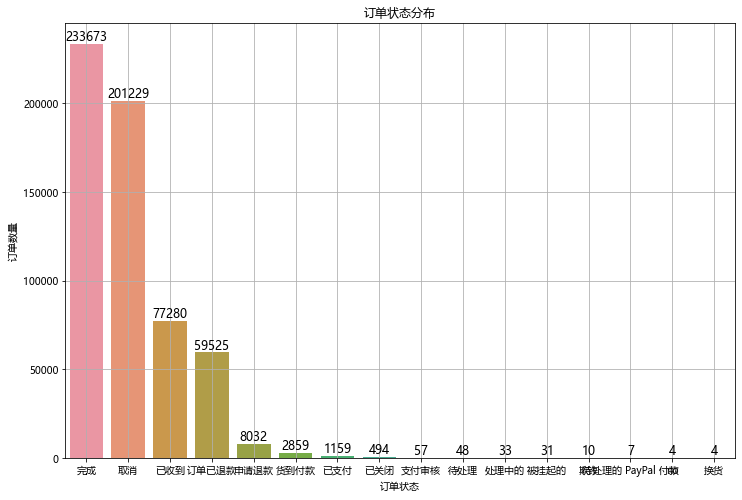

In [57]:
# 平台订单状态分布
plt.figure(figsize=(12,8))
temp = df.groupby('订单状态').count().sort_values('订单编号',ascending=False)

sns.barplot(x=temp.index,y='订单编号',data =temp)

for i, v in enumerate(df['订单状态'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
        
plt.grid()
plt.ylabel('订单数量')
plt.title('订单状态分布')
plt.show()

被判定为欺诈的订单数较少,无法提取有价值数据建模预测  
可以看出，用户的退换货比例相差悬殊，用户更倾向于退货，而不是换货。

订单状态
取消       201229
完成       233673
已收到       77280
申请退款       8032
订单已退款     59525
货到付款       2859
其他         1847
Name: 订单编号, dtype: int64


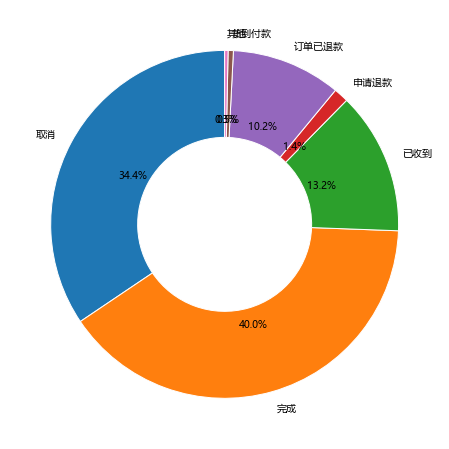

In [58]:
plt.figure(figsize=(12,8))
threshold = 2859 
pie_data = df.groupby('订单状态').count()['订单编号']

small_data = {k: v for k, v in pie_data.items()  if v  < threshold }
if len(small_data) > 0:
    pie_data['其他'] = sum(small_data.values())
    for k in small_data:
        del pie_data[k]
print(pie_data)
plt.pie(x=pie_data.values,labels=pie_data.index,autopct = '%1.1f%%', startangle=90,wedgeprops={'width': 0.5, 'edgecolor': 'w'})
plt.show()

### 分析
1.平台总订单中34,4%的取消订单,10.2%的订单退款.约有45%的订单异常.尝试建模,对订单的退款和取消进行预测.  
2.完成订单只有40.0%.另外有13.2%订单已经收到.需要收到订单进行核查了解已收到的业务意义. 明白已收到是近期产生的可能会发生变化的.还是长期存在的,相对固定的标签. 

In [59]:
# 已完成订单的预测 
df_temp = df[(df['订单状态']=='已收到')].groupby(['年份','月份'])['商品编号'].count().unstack()
df_temp

月份,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000
年份,,,,,,,,,,,,
2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,19.000000,74.000000,67.000000,2424.000000,273.000000
2017.000000,507.000000,196.000000,482.000000,2755.000000,5770.000000,4058.000000,3693.000000,5391.000000,1388.000000,1797.000000,6278.000000,1796.000000
2018.000000,1520.000000,2628.000000,7148.000000,1657.000000,11675.000000,6311.000000,4354.000000,4991.000000,NaN,NaN,NaN,NaN


已收到的订单最早的已收到订单产生于16年7月.而最晚的订单产生于18年8月.时间跨度比较大,并非是近期产生的状态不明确的订单.  
因此可以暂时认定为已收到订单也是正常订单.

In [60]:
df.columns

Index(['商品编号', '订单状态', '创建时间', 'SKU', '价格', '购买数量', '订单总额', '订单编号', '商品分类',
       '销售佣金代码', '折扣金额', '支付方式', '订单处理日期', 'BI状态', '市场价值', '年份', '月份',
       '客户注册时间', '月份和年份', '财年', '客户编号', '订单处理间隔', '用户复购间隔时间'],
      dtype='object')

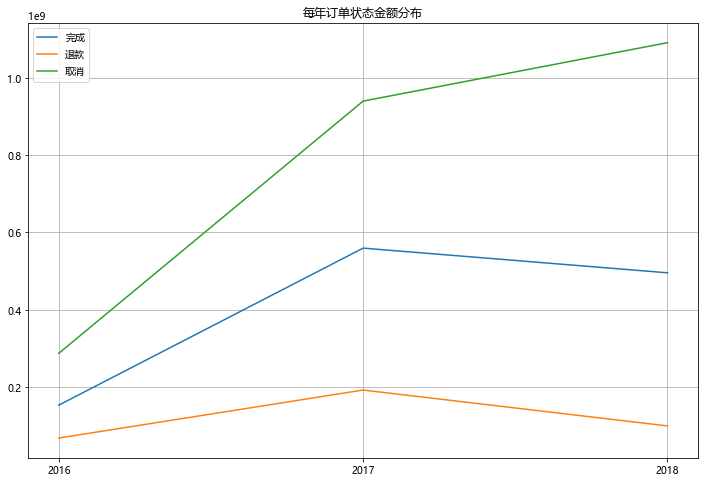

In [175]:
# 平台销售额情况 (没有计算退款和取消)
plt.figure(figsize=(12,8))
temp = df.groupby(['年份','订单状态'])['订单总额'].sum().to_frame()
temp.reset_index(inplace = True)
income = ['完成','已收到',]
refund =  ['订单已退款','申请退款']
cancel =  ['取消']

temp1 = temp[temp['订单状态'].isin(income)].groupby('年份').sum()
temp2 = temp[temp['订单状态'].isin(refund)].groupby('年份').sum()
temp3 = temp[temp['订单状态'].isin(cancel)].groupby('年份').sum() 

plt.plot(temp1,label = '完成')
plt.plot(temp2,label = '退款')
plt.plot(temp3,label = '取消')

plt.xticks(range(2016,2019))
plt.legend()
plt.grid()
plt.title('每年订单状态金额分布')
plt.show()


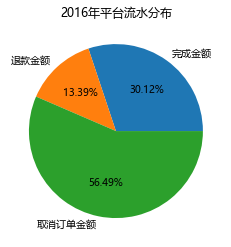

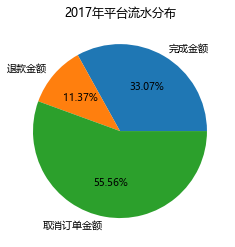

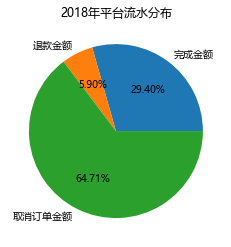

In [205]:
for i in range(0,3):
    
    labels = ['完成金额', '退款金额', '取消订单金额']
    data = [temp1.iloc[i,0],temp2.iloc[i,0],temp3.iloc[i,0]]
    plt.title(f'{2016+i}年平台流水分布')
    plt.pie(data, labels=labels, autopct='%.2f%%')
    plt.subplots_adjust(wspace=0.5)
    plt.show()

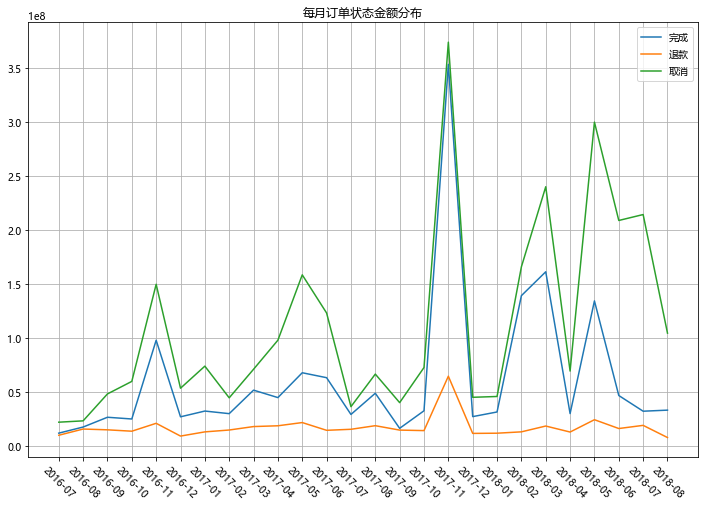

每个月平台完成的订单金额都比取消的多，结合取消的订单占比接近40%，说明平台在用户体验或运营策略上存在比较大的问题。
 缺少用户处理订单时间的字段，所以无法推测用户在取消之后用户的行为是怎么样的。


In [62]:
# 平台销售额情况
plt.figure(figsize=(12,8))
temp = df.groupby(['月份和年份','订单状态'])['订单总额'].sum().to_frame()
temp.reset_index(inplace = True)

temp1 = temp[temp['订单状态'].isin(income)].groupby('月份和年份').sum()
temp2 = temp[temp['订单状态'].isin(refund)].groupby('月份和年份').sum()
temp3 = temp[temp['订单状态'].isin(cancel)].groupby('月份和年份').sum() 

plt.plot(temp1.index.astype(str), temp1['订单总额'], label='完成')
plt.plot(temp2.index.astype(str), temp2['订单总额'], label='退款')
plt.plot(temp3.index.astype(str), temp3['订单总额'], label='取消')

plt.legend()
plt.xticks(rotation = -45)
plt.grid()
plt.title('每月订单状态金额分布')
plt.show()
print('每个月平台完成的订单金额都比取消的多，结合取消的订单占比接近40%，说明平台在用户体验或运营策略上存在比较大的问题。\n 缺少用户处理订单时间的字段，所以无法推测用户在取消之后用户的行为是怎么样的。')

# 用户列表

1.关联推荐  
2.数据可视化  
3.用户活跃度标签  
4.用户分层.  
5.复购预测

In [63]:
df_user.head()

,客户编号,末单日期,首单日期,SKU汇总,总消费额,总购买量,首单编号,总订单量,最大订单额,商品汇总,折扣总金额,历史支付方式,客户注册时间,销售佣金代码汇总,平均复购天数
0,1.000000,2016-07-01,2016-07-01,{'kreations_YI 06-L': 1},1950.000000,1.000000,100147443,1,1950.000000,{'女装时尚': 1},0.000000,[cod],2016-07,{},-1.000000
1,2.000000,2016-07-01,2016-11-25,{'kcc_Buy 2 Frey Air Freshener & Get 1 Kasual ...,510.000000,2.000000,100147444,2,270.000000,"{'美容与修饰': 1, '特产': 1}",0.000000,"[jazzvoucher, cod]",2016-07,{},73.000000
2,3.000000,2016-07-01,2017-05-19,"{'Ego_UP0017-999-MR0': 1, 'BT_BT-422': 1, 'ALH...",3695.000000,5.000000,100147445,2,2450.000000,"{'女装时尚': 1, '男装时尚': 2, '移动设备和平板电脑': 2}",0.000000,[cod],2016-07,{},64.200000
3,4.000000,2016-07-01,2018-08-27,"{'kcc_krone deal': 8, 'PC_1P SP CRW-006': 1, '...",2702416.500000,494.000000,100147446,387,85792.000000,"{'美容与修饰': 45, '男装时尚': 110, '超市': 14, '特产': 38,...",248547.050000,"[Payaxis, jazzwallet, Easypay, cod, jazzvouche...",2016-07,"{'R-FSD-52352': 388, 'FSD-RE-52352': 1, 'R-Fsd...",1.836449
4,5.000000,2016-07-01,2016-07-01,{'BK7010400AG': 1},555.000000,2.000000,100147447,1,1110.000000,{'特产': 1},0.000000,[cod],2016-07,{},-1.000000


In [64]:
# 用户购买的商品偏好
product_user_dict = {} # 每个用户购买的商品分类信息
product_total_dict = {} # 平台所有用户购买的商品分类(人次)

# 用自定义函数把它放进单元格中.
for user_id, category in df_user['商品汇总'].items():
    product_user_dict[user_id] ={}
    temp = []
    for product_name,count in dict(category).items():
        if product_name not in product_user_dict[user_id].keys():
            product_user_dict[user_id][product_name] = count
        else: 
            product_user_dict[user_id][product_name] += count  
            
        if product_name not in product_total_dict.keys():
            product_total_dict[product_name] = 1
        else:
            product_total_dict[product_name] += 1

In [65]:
# 用户购买的SKU偏好
sku_user_dict = {} # 每个用户购买的SKU信息
sku_total_dict = {} # 平台所有用户购买的SKU分类(人次)
# 用自定义函数把它放进单元格中.
for user_id, category in df_user['SKU汇总'].items():
    sku_user_dict[user_id] ={}

    for product_name,count in dict(category).items():
        if product_name not in sku_user_dict[user_id].keys():
            sku_user_dict[user_id][product_name] = count
        else: 
            sku_user_dict[user_id][product_name] += count    
            
        if product_name not in sku_total_dict.keys():
            sku_total_dict[product_name] = 1
        else:
            sku_total_dict[product_name] += 1

In [66]:
# 关联性的强弱,和目标商品出现在同一订单内的其他商品的频次.频次越高,关联性越强,频次越低,关联性越弱.
sku_recommend = {}
for num,name in sku_user_dict.items(): # num是序号 name是(商品品：数量)
    label_list = [i[0] for i in list(name.items()) if i[0] != 'not']  # 把每名用户的购买记录作为列表
    for label in label_list:  # 遍历用户购买的记录列表
        if label not in sku_recommend.keys():  # 如果标签不存在分类标签的列表中。 
            sku_recommend[label] = {}  # 把标签存入字典。
        else:
            for label1 in label_list:
                if label1 != label:
                    if label1 not in sku_recommend[label].keys():
                         sku_recommend[label][label1] = 1
                    else:
                         sku_recommend[label][label1] += 1
                else:
                    pass

for k,v in sku_recommend.items():
    sku_recommend[k] = dict(sorted(dict(sku_recommend[k]).items(),key=lambda x:x[1] ,reverse=True)[:5])                

In [67]:
recommend_list = {}
for i in df.groupby('订单编号')['SKU'].apply(lambda x: ';'.join(x)):
    product_list = i.split(';')
    return_list = {}
    filter_list = []
    for name in product_list:
        filter_list.append(name)
        for k,v in sku_recommend[name].items():
            if k not in return_list.keys():
                return_list[k] = v
            else:
                return_list[k] += v
    temp = []
    for k,v in return_list.items():
        if k in filter_list:
            temp.append(k)
        
        if v == 1:
            temp.append(k)
            
    temp = list(set(temp))
    for key in temp:
        del return_list[key]       
    
    recommend_list[i] = return_list
    # 这个推荐类别不区分用户标签。只是单纯统计数量，如果要精细化，还需要再添加用户的其他标签，在使用这个字典时增加对标签的判断。

In [68]:
for k,v in recommend_list.items():
    recommend_list[k] = dict(sorted(dict(recommend_list[k]).items(),key=lambda x:x[1] ,reverse=True)[:5])       

In [69]:
def check_recommend(x):
    res = {}
    ret = []
    try:
        if ';' in x:
            lis = x.split(';')
            for i in lis:
                ret.append(list(recommend_list[i].keys()))
            for dic in ret:
                for k,v in dic.items():
                    if k not in res.keys() and k not in lis:
                        res[k]  == v
                    else:
                        res[k] += v
        else:
            res = recommend_list[x]
        res = dict(sorted(res.items(),key=lambda x:x[1] ,reverse=True)[:5])       
        return res
    except:
        return res

In [70]:
df_user

,客户编号,末单日期,首单日期,SKU汇总,总消费额,总购买量,首单编号,总订单量,最大订单额,商品汇总,折扣总金额,历史支付方式,客户注册时间,销售佣金代码汇总,平均复购天数
0,1.000000,2016-07-01,2016-07-01,{'kreations_YI 06-L': 1},1950.000000,1.000000,100147443,1,1950.000000,{'女装时尚': 1},0.000000,[cod],2016-07,{},-1.000000
1,2.000000,2016-07-01,2016-11-25,{'kcc_Buy 2 Frey Air Freshener & Get 1 Kasual ...,510.000000,2.000000,100147444,2,270.000000,"{'美容与修饰': 1, '特产': 1}",0.000000,"[jazzvoucher, cod]",2016-07,{},73.000000
2,3.000000,2016-07-01,2017-05-19,"{'Ego_UP0017-999-MR0': 1, 'BT_BT-422': 1, 'ALH...",3695.000000,5.000000,100147445,2,2450.000000,"{'女装时尚': 1, '男装时尚': 2, '移动设备和平板电脑': 2}",0.000000,[cod],2016-07,{},64.200000
3,4.000000,2016-07-01,2018-08-27,"{'kcc_krone deal': 8, 'PC_1P SP CRW-006': 1, '...",2702416.500000,494.000000,100147446,387,85792.000000,"{'美容与修饰': 45, '男装时尚': 110, '超市': 14, '特产': 38,...",248547.050000,"[Payaxis, jazzwallet, Easypay, cod, jazzvouche...",2016-07,"{'R-FSD-52352': 388, 'FSD-RE-52352': 1, 'R-Fsd...",1.836449
4,5.000000,2016-07-01,2016-07-01,{'BK7010400AG': 1},555.000000,2.000000,100147447,1,1110.000000,{'特产': 1},0.000000,[cod],2016-07,{},-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115330,100498582,2018-03-27,2018-03-27,{'OTHPCB5AB351EEC46EC': 1},500.000000,4.000000,100498582,1,2000.000000,{'其他': 1},0.000000,[Easypay],2018-03,{},-1.000000
115331,100499821,2018-03-27,2018-03-27,{'MEFKAR5A7C138CE9EBD-L': 1},1040.000000,1.000000,100499821,1,1040.000000,{'男装时尚': 1},0.000000,[cod],2018-03,{},-1.000000
115332,100505460,2018-03-28,2018-03-28,{'OTHPCB5ABB207673754': 1},2000.000000,5.000000,100505460,1,10000.000000,{'其他': 1},0.000000,[Easypay],2018-03,{},-1.000000
115333,100480546,2018-03-15,2018-03-15,{'OTHPCB5A7D8A0DA56C6': 1},8000.000000,2.000000,100480546,1,16000.000000,{'其他': 1},0.000000,[Payaxis],2018-03,{},-1.000000


In [71]:
# 验证推荐效果,即,当一个用户购买了A商品后,在一个月内是否会购买B商品,如果是的话,就说明用户可能真的有这个需求.
# 如果可以在一开始购买的时候进行推荐,则可以发掘用户的购买需求
for n1 in range(1,21):
    cnt = 0
    recommend_cnt = 0
    res = 0
    # 检验字典的可用性
    df_user_list = df_user[df_user['总订单量']>2]['客户编号'].sample(200)
    temp_list_user_merge = pd.merge(df_user_list,df,how='left',on='客户编号')
    temp_list_user = temp_list_user_merge.groupby(['客户编号','订单编号','创建时间'])['SKU'].apply(lambda x: ';'.join(x)).sample(100,random_state=1).to_frame()
    temp_list_user.reset_index(inplace=True)
    temp_list_user['推荐商品'] = temp_list_user.apply(lambda x: check_recommend(x['SKU']),axis = 1)

    for uer_id,order_id,date in zip(temp_list_user['客户编号'],temp_list_user['订单编号'],temp_list_user['创建时间']):
        list_user = list(temp_list_user.iloc[cnt,4].keys())
        temp = df[(df['客户编号'] == uer_id) & (df['订单编号'] != order_id) & ((df['创建时间'] - pd.Timedelta(days=30)) < date)]

        temp_res = temp.groupby(['客户编号'])['SKU'].apply(lambda x: ';'.join(x)).to_dict()
        temp_res_list = []
        recommend_cnt += len(list_user)
        for value in temp_res.values():
            temp_res_list.extend(value.split(';'))

        temp_res = list(set(temp_res_list))

        count = len(set(list_user).intersection(set(temp_res)))
        res += count

        cnt += 1 
    print(f"第{n1}次试跑,推荐购买商品数:{recommend_cnt},在推荐列表中被购买商品的数:{res},准确率{round(res/recommend_cnt*100,2)}" )

第1次试跑,推荐购买商品数:299,在推荐列表中被购买商品的数:76,准确率25.42
第2次试跑,推荐购买商品数:189,在推荐列表中被购买商品的数:47,准确率24.87
第3次试跑,推荐购买商品数:319,在推荐列表中被购买商品的数:57,准确率17.87
第4次试跑,推荐购买商品数:335,在推荐列表中被购买商品的数:77,准确率22.99
第5次试跑,推荐购买商品数:302,在推荐列表中被购买商品的数:55,准确率18.21
第6次试跑,推荐购买商品数:299,在推荐列表中被购买商品的数:41,准确率13.71
第7次试跑,推荐购买商品数:318,在推荐列表中被购买商品的数:63,准确率19.81
第8次试跑,推荐购买商品数:293,在推荐列表中被购买商品的数:45,准确率15.36
第9次试跑,推荐购买商品数:345,在推荐列表中被购买商品的数:53,准确率15.36
第10次试跑,推荐购买商品数:289,在推荐列表中被购买商品的数:30,准确率10.38
第11次试跑,推荐购买商品数:296,在推荐列表中被购买商品的数:31,准确率10.47
第12次试跑,推荐购买商品数:318,在推荐列表中被购买商品的数:71,准确率22.33
第13次试跑,推荐购买商品数:299,在推荐列表中被购买商品的数:113,准确率37.79
第14次试跑,推荐购买商品数:357,在推荐列表中被购买商品的数:170,准确率47.62
第15次试跑,推荐购买商品数:280,在推荐列表中被购买商品的数:37,准确率13.21
第16次试跑,推荐购买商品数:236,在推荐列表中被购买商品的数:45,准确率19.07
第17次试跑,推荐购买商品数:322,在推荐列表中被购买商品的数:48,准确率14.91
第18次试跑,推荐购买商品数:350,在推荐列表中被购买商品的数:94,准确率26.86
第19次试跑,推荐购买商品数:377,在推荐列表中被购买商品的数:200,准确率53.05
第20次试跑,推荐购买商品数:301,在推荐列表中被购买商品的数:76,准确率25.25


<BarContainer object of 16 artists>

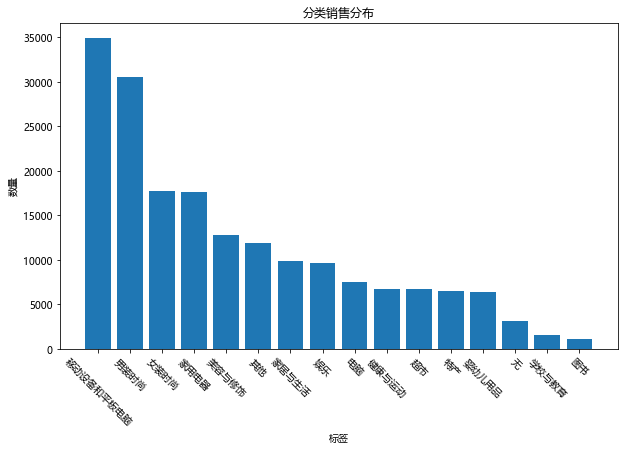

In [72]:
plt.figure(figsize=(10,6))

product_total_dict = dict(sorted(product_total_dict.items(),key=lambda x:x[1] ,reverse=True)) 

x = list(product_total_dict.keys())
y = list(product_total_dict.values())

plt.title('分类销售分布')
plt.xlabel('标签')
plt.ylabel('数量')
plt.xticks(rotation = -45)
plt.bar(x,y)


可以看出，平台销售的商品主要集中在小部分SKU。并不符合传统的二八定律,比较明显长尾


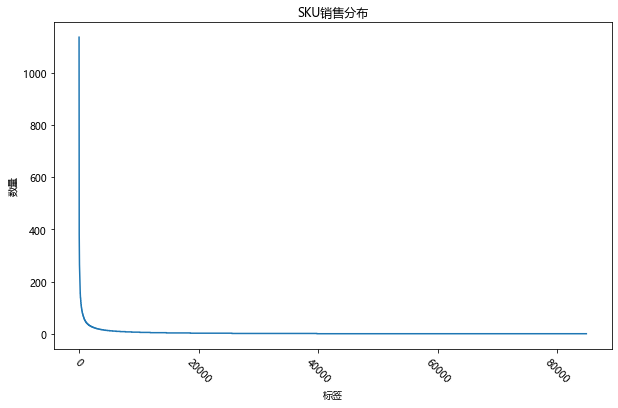

In [73]:
plt.figure(figsize=(10,6))

sku_total_dict = dict(sorted(sku_total_dict.items(),key=lambda x:x[1] ,reverse=True))
# print(sku_total_dict)
x = range(0,len(list(sku_total_dict.keys())))
y = list(sku_total_dict.values())

plt.title('SKU销售分布')
plt.xlabel('标签')
plt.ylabel('数量')
plt.xticks(rotation = -45)
plt.plot(x,y)


## 平台用户活跃分层

In [74]:
# 用户活跃标签:
df_pivoted = df.pivot_table(
    index = '客户编号',
    columns = '月份和年份',
    values = '购买数量',
    aggfunc = sum
)

In [75]:
df.describe()
# 用户首次购买时间隔为-1.

,商品编号,价格,购买数量,订单总额,折扣金额,年份,月份,订单处理间隔,用户复购间隔时间
count,584445.000000,584445.000000,584445.000000,584445.000000,584445.000000,584445.000000,584445.000000,584445.000000,584445.000000
mean,565651.294474,6349.203762,1.296394,8531.792132,499.476409,2017.044062,7.167703,0.000000,8.622380
std,200123.324086,14949.974173,3.996323,61324.874797,1507.016332,0.707365,3.486312,0.000000,41.104221
min,211131.000000,0.000000,1.000000,0.000000,0.000000,2016.000000,1.000000,0.000000,-1.000000
25%,394975.000000,360.000000,1.000000,945.200000,0.000000,2017.000000,4.000000,0.000000,0.000000
50%,568391.000000,899.000000,1.000000,1961.320000,0.000000,2017.000000,7.000000,0.000000,0.000000
75%,739100.000000,4070.000000,1.000000,6999.000000,160.191900,2018.000000,11.000000,0.000000,0.000000
max,905208.000000,1012625.900000,1000.000000,17888000.000000,90300.000000,2018.000000,12.000000,0.000000,754.000000


In [76]:
# 平均复购天数
print(f"剔除掉首单的-1天后.平台用户的平均复购天数是{round(df[df['用户复购间隔时间']>=0]['用户复购间隔时间'].mean(),2)}天")

剔除掉首单的-1天后.平台用户的平均复购天数是10.99天


In [77]:
def check_activity(x):
    lis = [0] * len(df_pivoted.columns)
    for i in range(len(x)):
        if not np.isnan(x[i]) and '新用户' not in lis:
            lis[i] = '新用户'

        elif np.isnan(x[i]) and lis[i-1] in ['流失用户','沉睡用户']:
            lis[i] =  '流失用户' 

        elif np.isnan(x[i]) and lis[i-1] in ['回流用户','正常用户','新用户','沉睡用户']:
            lis[i] =  '沉睡用户'
        
        elif not np.isnan(x[i]) and lis[i-1] in ['正常用户','沉睡用户','新用户','回流用户']:
            lis[i] =  '正常用户'
            
        elif not np.isnan(x[i]) and lis[i-1] in ['流失用户']:
            lis[i] =  '回流用户'

        elif np.isnan(x[i]):
            lis[i] = '未注册'

        else:
            lis[i] = x[i]
    return lis

In [78]:
df_pivoted_user = df_pivoted.apply(check_activity,axis=1)
df_user_activity = pd.DataFrame(df_pivoted_user.tolist(), columns=df_pivoted.columns, index=df_pivoted.index)


In [79]:
# 用户活跃等级
df_user_activity.head()

月份和年份,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
客户编号,,,,,,,,,,,,,,,,,,,,,
1.0,新用户,沉睡用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,...,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户
2.0,新用户,沉睡用户,流失用户,流失用户,回流用户,沉睡用户,流失用户,流失用户,流失用户,流失用户,...,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户
3.0,新用户,沉睡用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,...,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户
4.0,新用户,正常用户,正常用户,正常用户,正常用户,正常用户,正常用户,正常用户,正常用户,正常用户,...,正常用户,正常用户,正常用户,正常用户,沉睡用户,流失用户,流失用户,流失用户,流失用户,回流用户
5.0,新用户,沉睡用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,...,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户,流失用户


In [80]:
label_counts = df_user_activity.apply(pd.Series.value_counts).T
label_counts.fillna(0,inplace=True)
label_counts = label_counts[['新用户','正常用户','回流用户','沉睡用户']].astype(int)

<Figure size 1152x576 with 0 Axes>

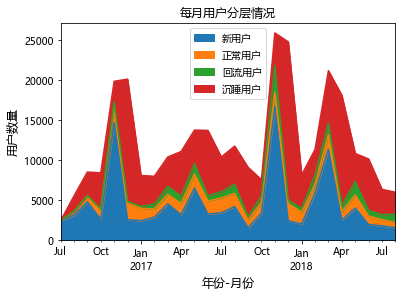

平台当前总用户为115335人,最近一个月活跃人数为5968人,平台有90%以上的不活跃用户



In [81]:
plt.figure(figsize = (16,8))

label_counts.plot.area()
plt.xlabel('年份-月份', fontsize=12)
plt.ylabel('用户数量', fontsize=12)
plt.title('每月用户分层情况')
plt.show()
print(f'平台当前总用户为{len(df_user_activity)}人,最近一个月活跃人数为{label_counts.iloc[-1].sum()}人,平台有90%以上的不活跃用户\n')

In [82]:
def check_act(df,x,y):
    return df.loc[x,y]

df['活跃标签'] =  df.apply(lambda x :check_act(df_user_activity,x['客户编号'],x['月份和年份']),axis=1)

In [83]:
df_user['最近一单日期'] = today - df_user['末单日期']
df_user['最近一单日期'] = df_user['最近一单日期']/np.timedelta64(1,'D')

In [84]:
df_user_rfm = df_user[['客户编号','最近一单日期','总订单量','总消费额']].copy()
df_user_rfm.columns = ['客户编号','R','F','M']

In [85]:
df_user_rfm.describe([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

,R,F,M
count,115335.000000,115335.000000,115335.000000
mean,399.375315,3.544050,32173.758117
std,210.545784,17.715895,191527.791266
min,0.000000,1.000000,0.000000
1%,20.000000,1.000000,129.000000
5%,95.000000,1.000000,340.000000
10%,147.000000,1.000000,500.000000
20%,181.000000,1.000000,899.000000
30%,275.000000,1.000000,1255.000000
40%,284.000000,1.000000,1998.000000


In [86]:
dic ={'111': '高价值客户',
    '110': '重点保持客户',
    '101': '重点发展客户',
    '100': '一般客户',
    '011': '重点挽留客户',
    '010': '一般挽留客户',
    '001': '重点流失客户',
    '000': '一般流失客户'}

def check(x1,x2,x3):
    s = x1 + x2 + x3
    return dic[s]
df_user_rfm
df_user_rfm['R值'] = df_user_rfm.apply(lambda x: '1' if x['R'] < 289 else '0',axis=1 )
df_user_rfm['F值'] = df_user_rfm.apply(lambda x: '1' if x['F'] > 1 else '0',axis=1 ) 
df_user_rfm['M值'] = df_user_rfm.apply(lambda x: '1' if x['M'] >3120 else '0',axis=1 )
df_user_rfm['RFM标签'] = df_user_rfm.apply(lambda x:check(x['R值'],x['F值'],x['M值']),axis=1)

In [87]:
df_user['RFM标签'] = df_user_rfm['RFM标签']

In [88]:
df_user.groupby('RFM标签')['客户编号'].count()

RFM标签
一般客户      17830
一般挽留客户     8739
一般流失客户    26050
重点保持客户     5068
重点发展客户     8633
重点挽留客户    22310
重点流失客户     9736
高价值客户     16969
Name: 客户编号, dtype: int64

In [89]:
def check_order_grade(x): # 订单分层
    if x< 1:
        return 0
    elif x< 3:
        return 1
    elif x< 50:
        return 2
    elif x< 100:
        return 3
    elif x< 200:
        return 4
    elif x < 300:
        return 5
    elif x< 700:
        return 6
    else:
        return 7


In [90]:
def check_amount_grade(x): #  金额分层
    if x< 360:
        return 0
    elif x < 1049:
        return 1
    elif x< 1350:
        return 2
    elif x< 1960:
        return 4
    elif x< 2920:
        return 5
    elif x< 4949:
        return 6
    elif x< 10599:
        return 7
    else:
        return 8

In [91]:
def check_cancel(x):
    if x == '取消':
        return '取消'
    else:
        return '其他'
    
def check_ref(x):
    if x == '申请退款' or x =='订单已退款':
        return '退款'
    else:
        return '其他'

df['退款标签'] = df.apply(lambda x:check_ref(x['订单状态']),axis =1 )
df['取消订单标签'] = df.apply(lambda x:check_cancel(x['订单状态']),axis =1 )
df['累计下单数'] = df.groupby('客户编号')['订单编号'].cumcount()
df['订单总额分级'] = df.apply(lambda x:check_amount_grade(x['订单总额']),axis=1)
df['有无佣金代码'] = df.apply(lambda x:'无' if x['销售佣金代码'] == 'no' else '有',axis=1)
df['累计下单数分级'] = df.apply(lambda x:check_order_grade(x['累计下单数']),axis=1)

In [92]:
df['累计取消订单数'] = df.groupby('客户编号')['取消订单标签'].transform(lambda x: (x == '取消').cumsum() - 1) 
df['累计退款订单数'] = df.groupby('客户编号')['退款标签'].transform(lambda x: (x == '退款').cumsum() - 1) 
df.replace([np.inf, -np.inf,-100,-1], 0, inplace=True)

df['累计退款订单率'] = round((df['累计退款订单数'] / df['累计下单数'])*100,2)
df['累计取消订单率'] = round((df['累计取消订单数'] / df['累计下单数'])*100,2)

df.fillna(0,inplace =True)

In [93]:
df_copy = df.copy()
df_drop = df.drop_duplicates(subset='订单编号',keep ='first')
df_cancel = df_drop.copy()
df = df.drop_duplicates(subset='订单编号',keep ='first')

In [94]:
df_cancel.columns

Index(['商品编号', '订单状态', '创建时间', 'SKU', '价格', '购买数量', '订单总额', '订单编号', '商品分类',
       '销售佣金代码', '折扣金额', '支付方式', '订单处理日期', 'BI状态', '市场价值', '年份', '月份',
       '客户注册时间', '月份和年份', '财年', '客户编号', '订单处理间隔', '用户复购间隔时间', '活跃标签', '退款标签',
       '取消订单标签', '累计下单数', '订单总额分级', '有无佣金代码', '累计下单数分级', '累计取消订单数', '累计退款订单数',
       '累计退款订单率', '累计取消订单率'],
      dtype='object')

### 探索什么样的用户更容易取消订单
猜测:  
1.订单处理间隔是否和订单取消有关系.  
2.客户注册时间是否和订单取消有关系.  
3.不同支付方式是否和订单取消有关系.  
4.不同商品分类是否和订单取消有关系.  
5.不同订单金额是否和订单取消有关系.  
6.有无佣金代码是否和订单取消有关系.  
7.不同活跃等级是否和订单取消有关系.  
8.用户历史行为是否和订单取消有关系  
9.BI状态和是否和订单取消有关系.


In [95]:
def plt_img(x):
    plt.figure(figsize=(8,4))
    temp = df_cancel.groupby(x)['取消订单标签'].value_counts().sort_values(ascending= False).to_frame()
    temp.rename(columns = {'取消订单标签':'数量'},inplace = True)
    temp.reset_index(inplace=True)
    sns.barplot(data =temp,x=x, y='数量',hue='取消订单标签')
    plt.title(f"{x}和取消订单数分布图")
    plt.xticks(rotation= -45)
    plt.grid()
    plt.show()

In [96]:
# 1.订单处理间隔是否和取消订单有关系.
df_cancel.groupby('订单处理间隔')['取消订单标签'].value_counts()

订单处理间隔    取消订单标签
0.000000  其他        260109
          取消        148644
Name: 取消订单标签, dtype: int64

In [97]:
print('平台的处理间隔都在当天处理,所以订单处理间隔是否和取消订单无关联')
df_cancel['订单处理间隔'].value_counts()

平台的处理间隔都在当天处理,所以订单处理间隔是否和取消订单无关联


0.000000    408753
Name: 订单处理间隔, dtype: int64

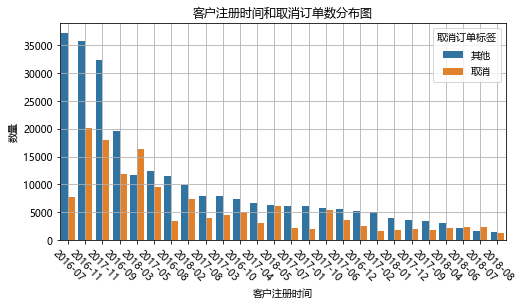

In [98]:
# 2.客户注册时间是否和取消订单有关系.  
plt_img('客户注册时间')

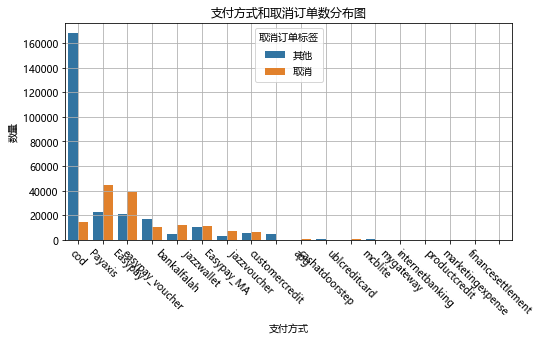

In [99]:
# 3.不同支付方式是否和订单取消有关系. 
plt_img('支付方式')

支付方式和取消订单存在一定关系.

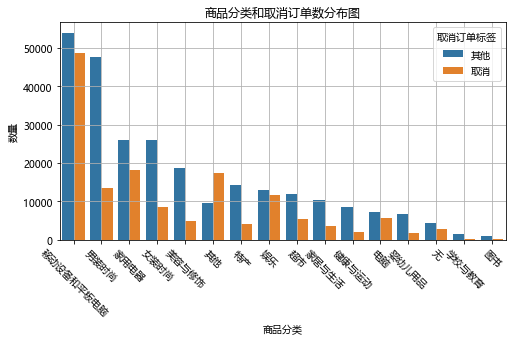

In [100]:
# 4.不同商品分类是否和订单取消有关系.
plt_img('商品分类')

可以看出,不同商品种类取消的的分布有明显的不同

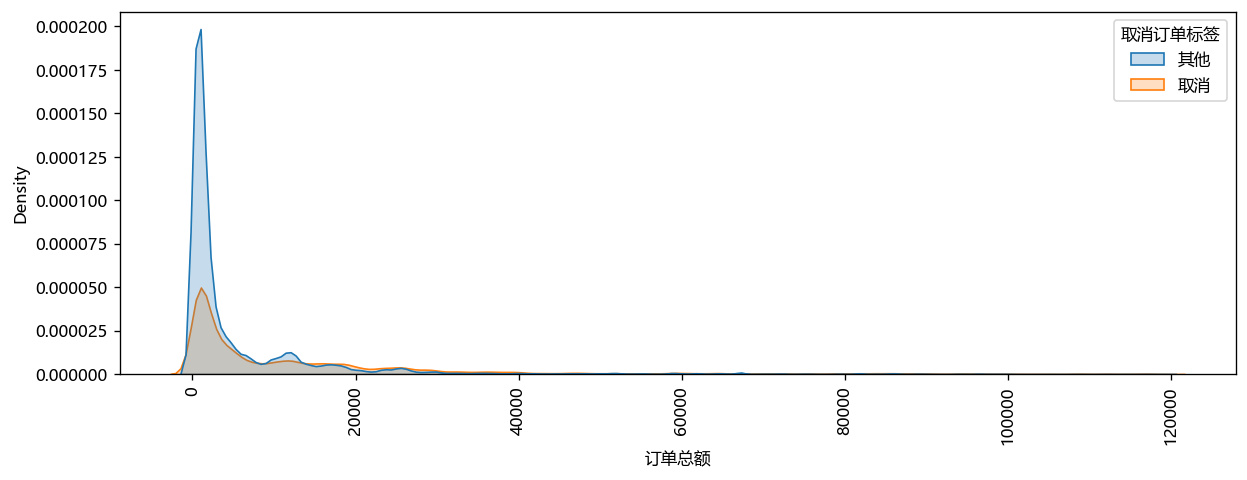

In [101]:
# 5.不同订单金额是否和订单取消有关系. 
plt.figure(figsize=(12,4),dpi=120)
df_cancel1  = df_cancel[df_cancel['订单总额']<119254.000000]
temp = df_cancel1.groupby('订单总额')['取消订单标签'].value_counts().sort_values(ascending= False).to_frame()
temp.rename(columns = {'取消订单标签':'数量'},inplace = True)
temp.reset_index(inplace=True)

sns.kdeplot(data =df_cancel1,x='订单总额',hue='取消订单标签',shade=True,bw_adjust=0.5)
plt.xticks(rotation= 90)
plt.show()

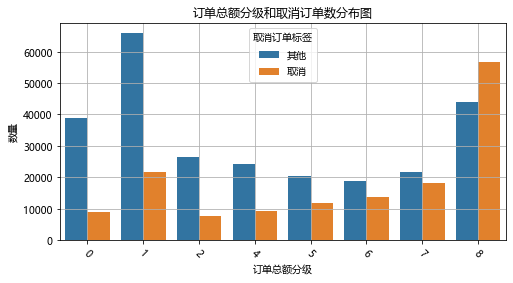

In [102]:
plt_img('订单总额分级')

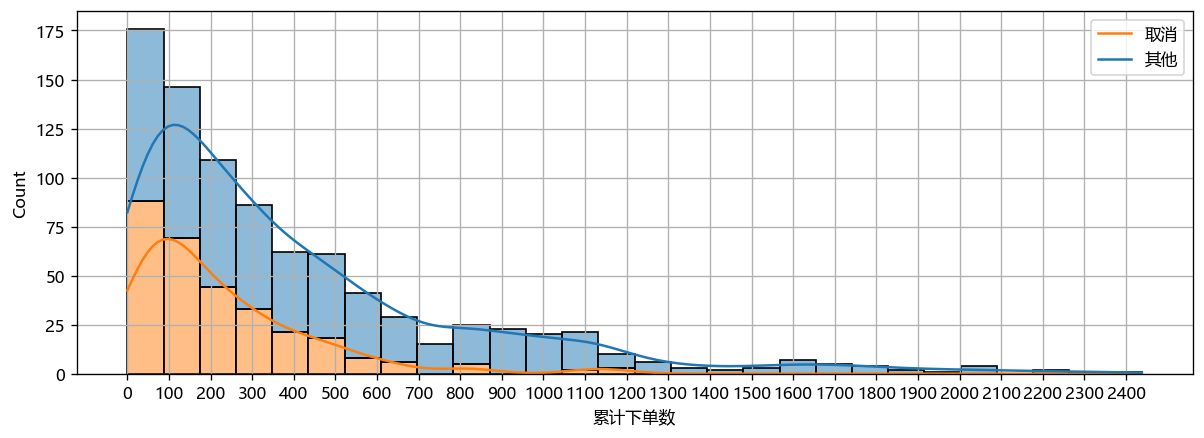

In [103]:
# 6.累计下单数是否和订单取消有关系. 
plt.figure(figsize=(12, 4), dpi=120)
temp = df_cancel.sample(10000)
temp = temp.groupby(['累计下单数', '取消订单标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='累计下单数', hue='取消订单标签', multiple='stack', kde=True)
plt.xticks(np.arange(temp['累计下单数'].min(), temp['累计下单数'].max(), 100))
plt.legend(labels=['取消', '其他'])
plt.grid()

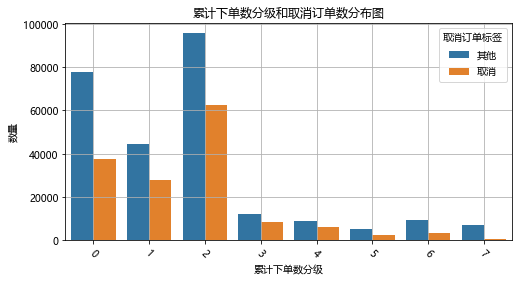

In [104]:
plt_img('累计下单数分级')

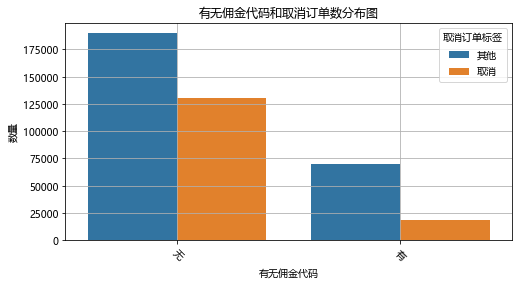

In [105]:
# 6.有无佣金代码是否和订单取消有关系.
plt_img('有无佣金代码')

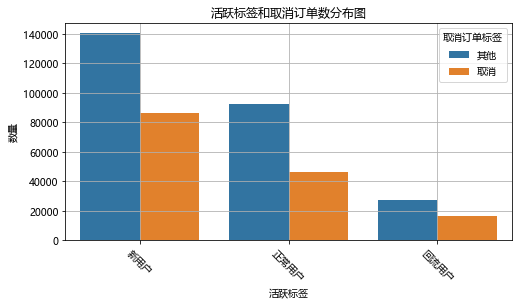

In [106]:
plt_img('活跃标签')

In [107]:
df_cancel.columns

Index(['商品编号', '订单状态', '创建时间', 'SKU', '价格', '购买数量', '订单总额', '订单编号', '商品分类',
       '销售佣金代码', '折扣金额', '支付方式', '订单处理日期', 'BI状态', '市场价值', '年份', '月份',
       '客户注册时间', '月份和年份', '财年', '客户编号', '订单处理间隔', '用户复购间隔时间', '活跃标签', '退款标签',
       '取消订单标签', '累计下单数', '订单总额分级', '有无佣金代码', '累计下单数分级', '累计取消订单数', '累计退款订单数',
       '累计退款订单率', '累计取消订单率'],
      dtype='object')

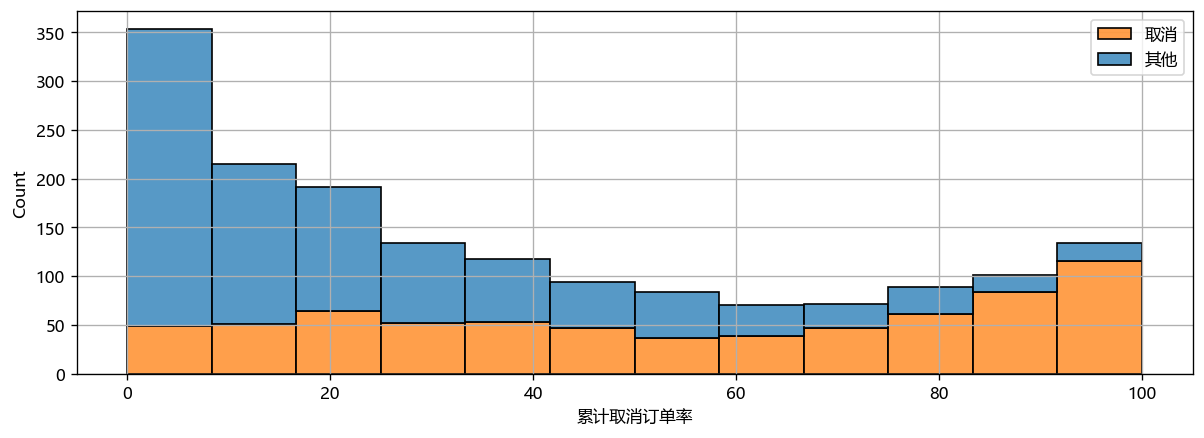

In [108]:
# 6.累计下单数是否和订单取消有关系. 
plt.figure(figsize=(12, 4), dpi=120)

temp = df_cancel.sample(10000)
temp = temp.groupby(['累计取消订单率', '取消订单标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='累计取消订单率', hue='取消订单标签', multiple='stack', kde=False)
plt.legend(labels=['取消', '其他'])
plt.grid()

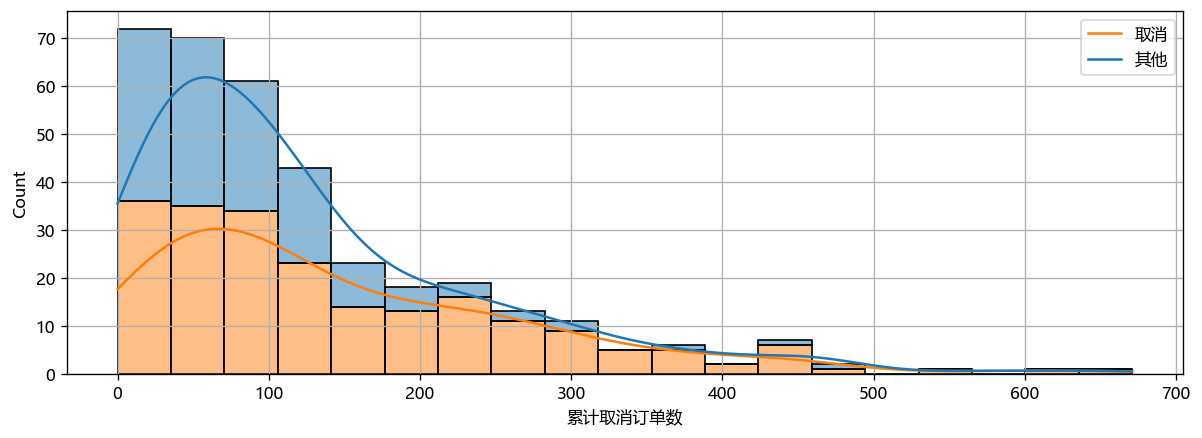

In [109]:
plt.figure(figsize=(12, 4), dpi=120)

temp = df_cancel.sample(10000)
temp = temp.groupby(['累计取消订单数', '取消订单标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='累计取消订单数', hue='取消订单标签', multiple='stack', kde=True)
plt.legend(labels=['取消', '其他'])
plt.grid()

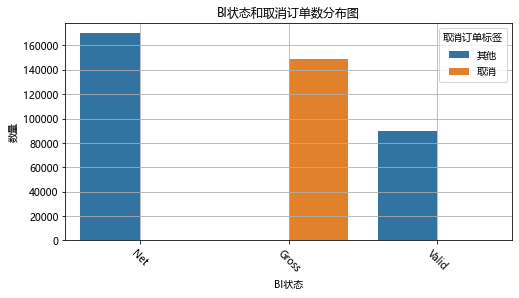

可以看出所有有问题的用户都是属于同一类别.关联性明显


In [110]:
# 不同BI标签是否和退款有关系
plt_img('BI状态')
print('可以看出所有有问题的用户都是属于同一类别.关联性明显')

In [111]:
df_cancel_predict = df_cancel[['取消订单标签','客户注册时间','商品分类','活跃标签','累计取消订单率', '累计取消订单数',
 '有无佣金代码','累计退款订单率','累计退款订单数','累计下单数','SKU','支付方式','订单总额','价格']]
# 第一次使用包括BI状态的数据运行模型的时候,发现准确率达到100%.不确定这个特征值是事前知道的,还是事后归类的.所以这个特征放弃.

In [112]:
le = LabelEncoder()
sca = StandardScaler()
for i in df_cancel_predict.columns:
    df_cancel_predict[i] = le.fit_transform(df_cancel_predict[i])
    
pred = df_cancel_predict.copy()
pred1 = pred.drop('取消订单标签',axis=1)

In [113]:
df_cancel_predict_model1 = df_cancel_predict[df_cancel_predict['取消订单标签']==0].sample(n=6000, random_state=1)
df_cancel_predict_model2 = df_cancel_predict[df_cancel_predict['取消订单标签']==1].sample(n=4000, random_state=1)
df_cancel_predict = pd.concat([df_cancel_predict_model1,df_cancel_predict_model2])
df_cancel_predict = df_cancel_predict.sample(frac=1).reset_index(drop=True)

X = df_cancel_predict.drop('取消订单标签',axis=1)
y = df_cancel_predict['取消订单标签']
X = sca.fit_transform(X)

train_x, test_x,train_y, test_y = train_test_split(X,y, test_size=0.3, random_state=42,shuffle=y,stratify=y)

In [114]:
# 构造各种分类器
classifiers = [  
                DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
                AdaBoostClassifier(random_state = 1,n_estimators=80), 
                RandomForestClassifier(random_state = 1, criterion = 'gini'),
]
# 分类器名称
classifier_names = [
            'decisiontreeclassifier',
            'adaboostclassifier',
            'randomforestclassifier',
]
# 分类器参数
#注意分类器的参数，字典键的格式，GridSearchCV对调优的参数格式是"分类器名"+"__"+"参数名"
classifier_param_grid = [
            {'decisiontreeclassifier__max_depth':[4,5,6,9,11]},
            {'adaboostclassifier__n_estimators':[60,70,80,90,100],'adaboostclassifier__learning_rate':[0.1,0.2,1,2]},
            {
            'randomforestclassifier__n_estimators':[100,200,300,400,500],
            'randomforestclassifier__min_samples_split':[1,2,3,4,5], 
 },          ]

In [115]:
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score='accuracy_score'):
    class_weight = {0: 0.2, 1: 0.8}  # 根据需要设置权重比例，这里的示例是0类权重为0.2，1类权重为0.8

    response = {}
    gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring=score)
    # 寻找最优的参数和最优的准确率分数
    search = gridsearch.fit(train_x, train_y, **{f'{model_name}__sample_weight': train_y.map(class_weight)})
    print(f"GridSearch 最优参数：{search.best_params_}")
    print(f"GridSearch 最优分数：{format(search.best_score_,'.4f')}")
    
    # 采用predict函数（特征是测试数据集）来预测标识，预测使用的参数是上一步得到的最优参数
    predict_y = gridsearch.predict(test_x)
    accuracy = accuracy_score(test_y, predict_y)
    recall = metrics.recall_score(test_y, predict_y)
    precision = metrics.precision_score(test_y, predict_y)
    f1 = metrics.f1_score(test_y, predict_y)
    
    best_model = search.best_estimator_
    
    print(f"准确率：{format(accuracy,'.4f')},召回率：{format(recall,'.4f')},精确度：{format(precision,'.4f')}, F1分数：{format(f1,'.4f')}")
    predict_y = best_model.predict(test_x)
    response['best_model'] = best_model
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy
    response['recall_score'] = recall
    response['precision_score'] = precision
    response['f1_score'] = f1
    return response

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    # 采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
        (model_name, model)
    ])
    model = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score='accuracy')
    best_model = model['best_model']
    print(best_model)

GridSearch 最优参数：{'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数：0.7831
准确率：0.7850,召回率：0.9392,精确度：0.6633, F1分数：0.7775
Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=1))])
GridSearch 最优参数：{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
GridSearch 最优分数：0.7867
准确率：0.7963,召回率：0.9233,精确度：0.6810, F1分数：0.7839
Pipeline(steps=[('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=1, n_estimators=100,
                                    random_state=1))])
GridSearch 最优参数：{'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__n_estimators': 300}
GridSearch 最优分数：0.8117
准确率：0.8140,召回率：0.7800,精确度：0.7610, F1分数：0.7704
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=4, n_estimators=300,
                                        random_state=1))])


In [116]:
model = RandomForestClassifier(min_samples_split=5, n_estimators=500,
                                        random_state=1)
model.fit(train_x,train_y)
pred2 = sca.fit_transform(pred1)
pred_prob = model.predict_proba(pred2)[:, 1]
threshold = 0.6
pred_adjusted = (pred_prob >= threshold).astype(int)

pred['预测'] = pred_adjusted # 原始数据集

In [117]:
print('所有数据的预测准确率是:',round((len(pred[pred['预测']==pred['取消订单标签']])) / 408785*100,2),'%')
print(
        f'对原数据的试跑中\n实际为1的数量:{len(pred[pred["取消订单标签"]== 1])},'
        f'\n预测为1的数量:{len(pred[pred["预测"]== 1])},'
        f'\n实际为0的数量:{len(pred[pred["取消订单标签"]== 0])},'
        f'\n预测为0的数量:{len(pred[pred["预测"]== 0])},'
        f'\n预测为1准确的数量是:{len(pred[(pred["预测"]== 1)& (pred["取消订单标签"]== 1)])}'
        f'\n预测为1错误的数量是:{len(pred[(pred["预测"]== 1 )& (pred["取消订单标签"]== 0)])}'
        f'\n预测为1错误率是:{round(len(pred[(pred["预测"]== 1 )& (pred["取消订单标签"]== 0)]) / len(pred[pred["预测"]== 1]),2)}'
)

所有数据的预测准确率是: 81.29 %
对原数据的试跑中
实际为1的数量:148644,
预测为1的数量:120609,
实际为0的数量:260109,
预测为0的数量:288144,
预测为1准确的数量是:96394
预测为1错误的数量是:24215
预测为1错误率是:0.2


In [118]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

cr_train = classification_report(train_y, train_pred)
cr_test = classification_report(test_y, test_pred)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)

In [119]:
print('1. 训练分类报告 : \n')
print(cr_train)
print('\n\n2. 测试分类报告 : \n')
print(cr_test)

1. 训练分类报告 : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4200
           1       0.99      0.97      0.98      2800

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000



2. 测试分类报告 : 

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1800
           1       0.78      0.75      0.76      1200

    accuracy                           0.82      3000
   macro avg       0.81      0.80      0.81      3000
weighted avg       0.81      0.82      0.81      3000



# 用户退款预测

In [120]:
df_refund = df_drop.copy()

### 探索什么样的用户更容易退款
猜测:  
1.客户注册时间是否和退款有关系.  
2.不同支付方式是否和退款有关系.  
3.不同商品分类是否和退款有关系.  
4.不同订单金额是否和退款有关系.  
5.有无佣金代码是否和退款有关系.  
6.用户历史行为和退款是否有关系.  
7.BI状态是否和退款是否有关系.


In [121]:
def plt_img(x):
    plt.figure(figsize=(8,4))
    temp = df_refund.groupby(x)['退款标签'].value_counts().sort_values(ascending= False).to_frame()
    temp.rename(columns = {'退款标签':'数量'},inplace = True)
    temp.reset_index(inplace=True)
    sns.barplot(data =temp,x=x, y='数量',hue='退款标签')
    plt.title(f"{x}和退款订单数分布图")
    plt.xticks(rotation= -45)
    plt.show()

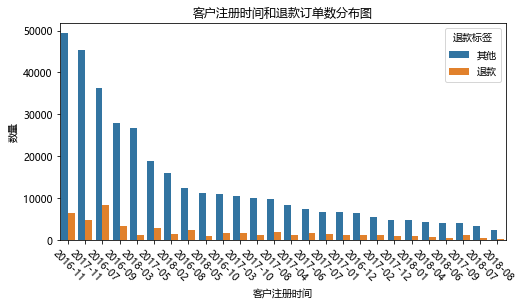

In [122]:
# 1.客户注册时间是否和取消订单有关系.  
plt_img('客户注册时间')

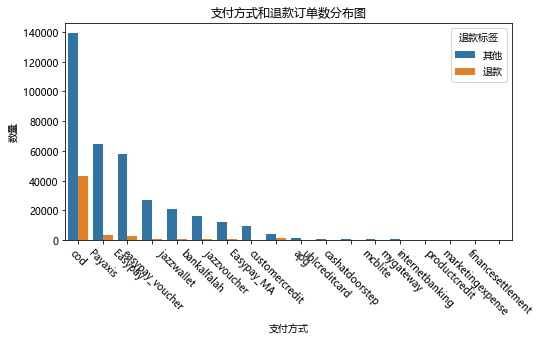

In [123]:
# 2.不同支付方式是否和订单取消有关系. 
plt_img('支付方式')

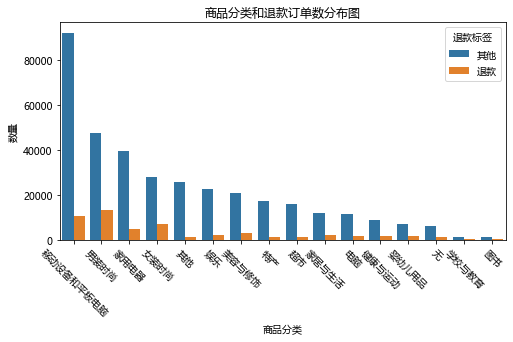

In [124]:
# 3.不同商品分类是否和订单取消有关系.
plt_img('商品分类')

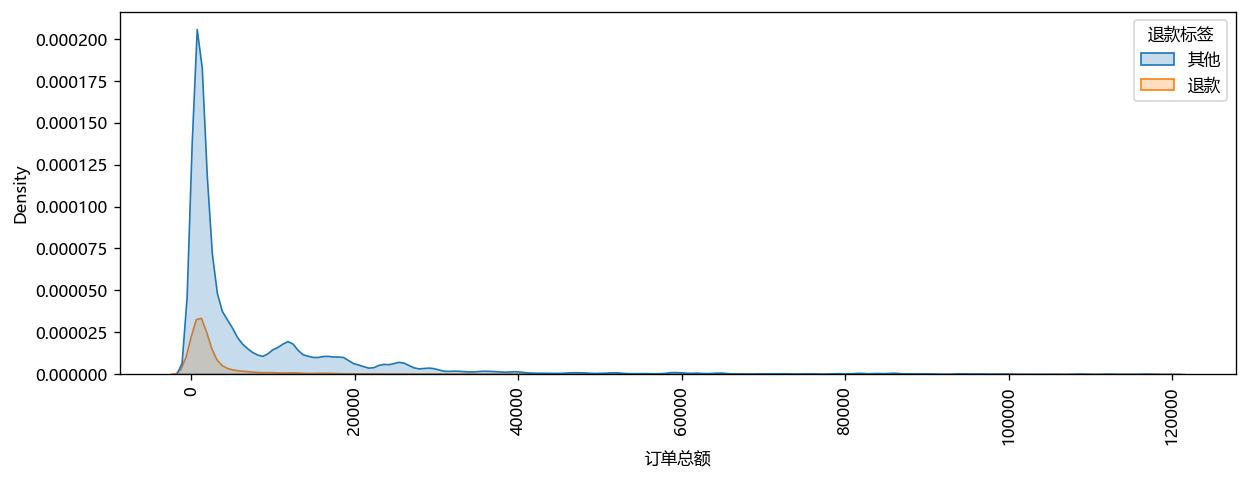

In [125]:
# 4.不同订单金额是否和订单取消有关系. 
plt.figure(figsize=(12,4),dpi=120)
df_refund1  = df_refund[df_refund['订单总额']<119254.000000]
temp = df_refund1.groupby('订单总额')['退款标签'].value_counts().sort_values(ascending= False).to_frame()
temp.rename(columns = {'退款标签':'数量'},inplace = True)
temp.reset_index(inplace=True)

sns.kdeplot(data =df_refund1,x='订单总额',hue='退款标签',shade=True,bw_adjust=0.5)
plt.xticks(rotation= 90)
plt.show()

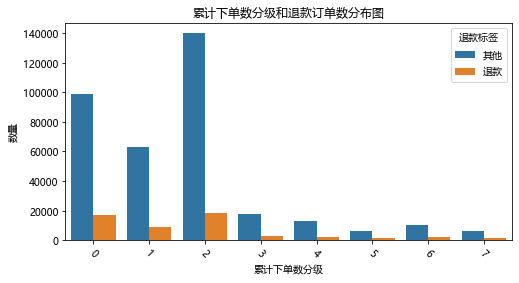

In [126]:
plt_img('累计下单数分级')

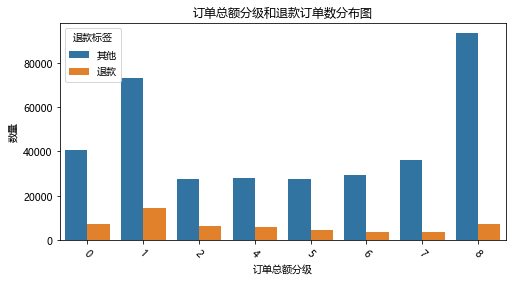

In [127]:
plt_img('订单总额分级')

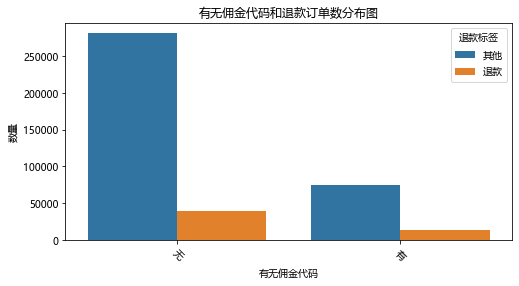

In [128]:
# 5.有无佣金代码是否和订单取消有关系.
plt_img('有无佣金代码')

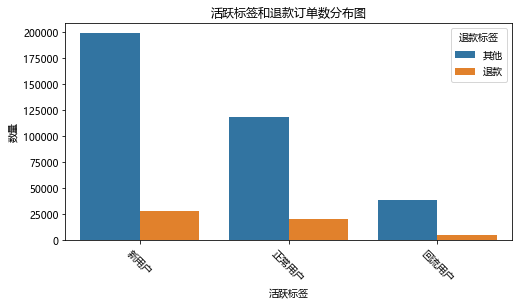

In [129]:
# 6.不同活跃标签是否和订单取消有关系.
plt_img('活跃标签')

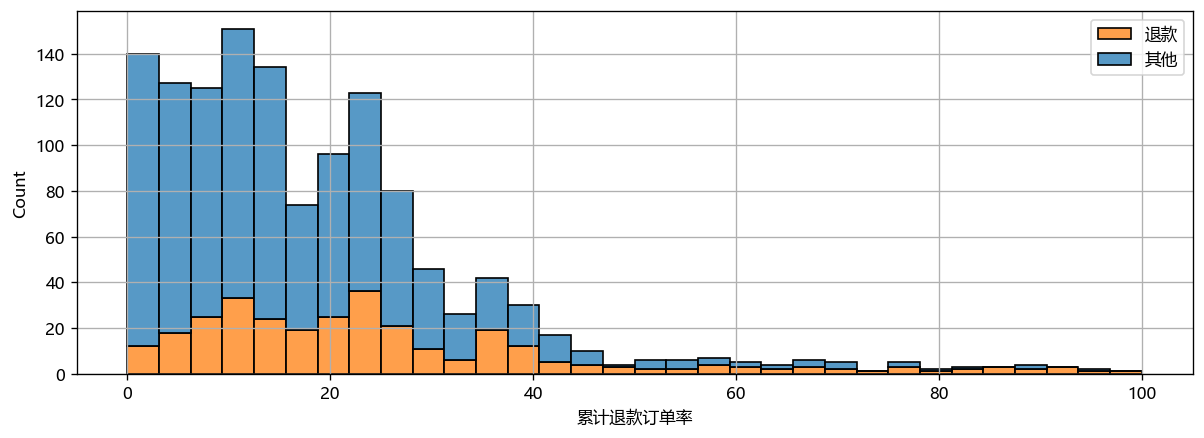

In [130]:
# 7.用户过去行为是否和退款消有关系. 
plt.figure(figsize=(12, 4), dpi=120)

temp = df_cancel.sample(10000)
temp = temp.groupby(['累计退款订单率', '退款标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='累计退款订单率', hue='退款标签', multiple='stack', kde=False)
plt.legend(labels=['退款', '其他'])
plt.grid()

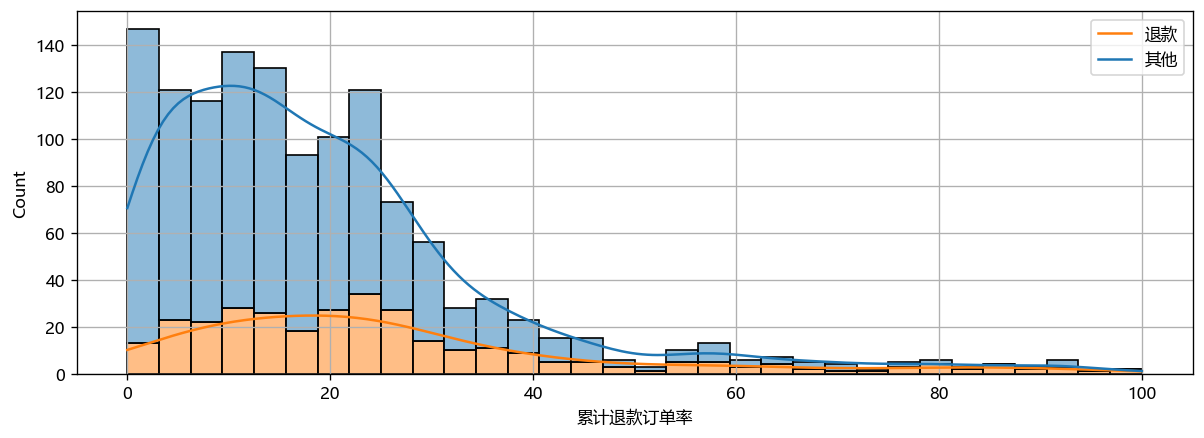

In [131]:
plt.figure(figsize=(12, 4), dpi=120)

temp = df_cancel.sample(10000)
temp = temp.groupby(['累计退款订单率', '退款标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='累计退款订单率', hue='退款标签', multiple='stack', kde=True)
plt.legend(labels=['退款', '其他'])
plt.grid()

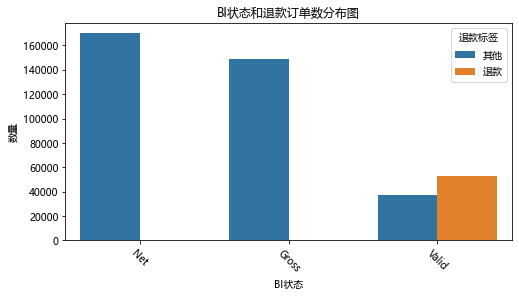

In [132]:
#8.BI状态是否和退款有关系.
plt_img('BI状态')

In [218]:
df_refund_predict = df_refund[['退款标签','客户注册时间','商品分类','活跃标签','累计取消订单率', '累计取消订单数',
 '有无佣金代码','累计退款订单率','累计退款订单数','累计下单数','SKU','支付方式','订单总额','价格']]
# 结果同前边的预测.BI特征的相关性太高.为了模型准确性，舍弃该特征

In [219]:
le = LabelEncoder()
sca = StandardScaler()
for i in df_refund_predict.columns:
    df_refund_predict[i] = le.fit_transform(df_refund_predict[i])

pred = df_refund_predict.copy()
pred1 = pred.drop('退款标签',axis=1)

In [220]:
df_refund_predict_model1 = df_refund_predict[df_refund_predict['退款标签']==0].sample(n=6000, random_state=1)
df_refund_predict_model2 = df_refund_predict[df_refund_predict['退款标签']==1].sample(n=2000, random_state=1)
df_refund_predict = pd.concat([df_refund_predict_model1,df_refund_predict_model2])
df_refund_predict = df_refund_predict.sample(frac=1).reset_index(drop=True)

X = df_refund_predict.drop('退款标签',axis=1)
y = df_refund_predict['退款标签']

X = sca.fit_transform(X)

train_x, test_x,train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [221]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    # 采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
        (model_name, model)
    ])
    model = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score='accuracy')
    best_model = model['best_model']
    print(best_model)

GridSearch 最优参数：{'decisiontreeclassifier__max_depth': 9}
GridSearch 最优分数：0.6706
准确率：0.6694,召回率：0.8175,精确度：0.4176, F1分数：0.5528
Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=9, random_state=1))])
GridSearch 最优参数：{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
GridSearch 最优分数：0.6897
准确率：0.6875,召回率：0.8200,精确度：0.4339, F1分数：0.5675
Pipeline(steps=[('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=1, n_estimators=100,
                                    random_state=1))])
GridSearch 最优参数：{'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
GridSearch 最优分数：0.7852
准确率：0.7875,召回率：0.3325,精确度：0.6456, F1分数：0.4389
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])


In [248]:
model =  RandomForestClassifier(min_samples_split=2, n_estimators=100,random_state=1)
model.fit(train_x,train_y)
pred2 = sca.fit_transform(pred1)
pred_prob = model.predict_proba(pred2)[:, 1]
threshold = 0.59
pred_adjusted = (pred_prob >= threshold).astype(int)

pred['预测'] = pred_adjusted # 原始数据集


In [249]:
# 在原数据集中的表现.全部数据一共408785 
print('所有数据的预测准确率是:',round((len(pred[pred['预测']== pred['退款标签']])) / 408785*100,2),'%')
print(
        f'对原数据的试跑中\n实际为1的数量:{len(pred[pred["退款标签"]== 1])},'
        f'\n预测为1的数量:{len(pred[pred["预测"]== 1])},'
        f'\n实际为0的数量:{len(pred[pred["退款标签"]== 0])},'
        f'\n预测为0的数量:{len(pred[pred["预测"]== 0])},'
        f'\n预测为1准确的数量是:{len(pred[(pred["预测"]== 1)& (pred["退款标签"]== 1)])}'
        f'\n预测为1错误的数量是:{len(pred[(pred["预测"]== 1 )& (pred["退款标签"]== 0)])}'
        f'\n预测为1错误率是:{round(len(pred[(pred["预测"]== 1 )& (pred["退款标签"]== 0)]) / len(pred[pred["预测"]== 1]),2)}'
)

print('\n因为退款和未退款的比例分布为13比87,数据分布不均衡.调整模型判断的阈值,降低模型判断退款的数量.使判断准确率维持在50~60之间.')
print('减少因为样本不均衡,导致判断退款的数量过大而产生的额外损耗')      

所有数据的预测准确率是: 87.19 %
对原数据的试跑中
实际为1的数量:53151,
预测为1的数量:27794,
实际为0的数量:355602,
预测为0的数量:380959,
预测为1准确的数量是:14300
预测为1错误的数量是:13494
预测为1错误率是:0.49

因为退款和未退款的比例分布为13比87,数据分布不均衡.调整模型判断的阈值,降低模型判断退款的数量.使判断准确率维持在50~60之间.
减少因为样本不均衡,导致判断退款的数量过大而产生的额外损耗


In [140]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

cr_train = classification_report(train_y, train_pred)
cr_test = classification_report(test_y, test_pred)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)

In [141]:
print('1. 训练分类报告 : \n')
print(cr_train)
print('\n\n2. 测试分类报告 : \n')
print(cr_test)

1. 训练分类报告 : 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4000
           1       1.00      0.99      0.99      2400

    accuracy                           1.00      6400
   macro avg       1.00      0.99      1.00      6400
weighted avg       1.00      1.00      1.00      6400



2. 测试分类报告 : 

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1000
           1       0.67      0.60      0.63       600

    accuracy                           0.74      1600
   macro avg       0.72      0.71      0.71      1600
weighted avg       0.73      0.74      0.74      1600



# 探索用户复购的可能性
猜测:   
1.不同支付方式是否和复购有关系.  
2.不同商品分类是否和复购有关系.  
3.不同订单金额是否和复购有关系.  
4.有无佣金代码是否和复购有关系.  
5.不同活跃等级是否和复购有关系.  
6.用户历史行为是否和复购有关系  

In [142]:
def plt_img(df,x):
    plt.figure(figsize=(8,4))
    temp = df.groupby(x)['复购标签'].value_counts().sort_values(ascending= False).to_frame()
    temp.rename(columns = {'复购标签':'数量'},inplace = True)
    temp.reset_index(inplace=True)
    sns.barplot(data =temp,x=x, y='数量',hue='复购标签')
    plt.xticks(rotation= 90)
    plt.show()

In [143]:
#  建立用户信息表
df_copy_temp = df_user[['首单编号']]
df_user_table = pd.merge(df_copy,df_copy_temp,how='right',left_on='订单编号',right_on='首单编号')
df_user_table
df_first_product = df_user_table.copy()
df_user_table.drop_duplicates('订单编号',keep = 'first',inplace=True)

In [144]:
# 提取首单相关信息
col1 = df_first_product.groupby('客户编号')['SKU'].apply(lambda x:';'.join(x)).rename('首单SKU').to_frame()
col2 = df_first_product.groupby('客户编号')['商品分类'].apply(lambda x:';'.join(x)).rename('首单商品分类').to_frame()
col3 = df_first_product.groupby('客户编号')['购买数量'].sum().to_frame().rename(columns={'购买数量':'首单购买总量'})
col4 = df_first_product.groupby('客户编号')['折扣金额'].sum().to_frame().rename(columns={'折扣金额':'首单折扣金额'})

df_temp = pd.concat([col1, col2, col3, col4], axis=1)

In [145]:
# 从用户列表中取相关信息
df_user_repurchase =  df_user_table.loc[:,['客户编号','有无佣金代码','客户注册时间','支付方式','销售佣金代码','订单总额' ]]

# 从用户汇总信息表中提取信息
df_user_table_ = df_user.loc[:,['客户编号','总订单量']]
df_user_table_['复购标签'] = df_user_table_.apply(lambda x:1 if x['总订单量']>1 else 0,axis=1)
df_user_table_ = df_user_table_.set_index('客户编号')
df_user_repurchase = df_user_repurchase.set_index('客户编号')

# 把3个列表信息合并.
df_user_repurchase = pd.concat([df_user_table_,df_user_repurchase,df_temp],axis=1)


In [262]:
df_user_repurchase['复购标签'].value_counts()

0    62249
1    53086
Name: 复购标签, dtype: int64

In [146]:
df_user_repurchase.groupby(['复购标签'])['首单购买总量'].value_counts()

复购标签  首单购买总量    
0       1.000000    43871
        2.000000     9795
        3.000000     3631
        4.000000     1889
        5.000000     1880
                    ...  
1     111.000000        1
      120.000000        1
      198.000000        1
      273.000000        1
      300.000000        1
Name: 首单购买总量, Length: 102, dtype: int64

In [147]:
df_user_repurchase = df_user_repurchase.drop('总订单量',axis=1)

In [148]:
from statistics import mode
df_user_repurchase['首单商品分类数量'] = df_user_repurchase.apply(lambda x: len(list(set(x['首单商品分类'].split(';')))),axis=1)

def check_max(x):
    lis = pd.Series(x.split(';'))
    return mode(lis)
    
df_user_repurchase['首单商品主分类'] = df_user_repurchase.apply(lambda x: check_max(x['首单商品分类']),axis=1)
df_user_repurchase['首单SKU数量'] = df_user_repurchase.apply(lambda x: len(list(set(x['首单SKU'].split(';')))),axis=1)
df_user_repurchase['首单SKU主分类'] = df_user_repurchase.apply(lambda x: check_max(x['首单SKU']),axis=1)

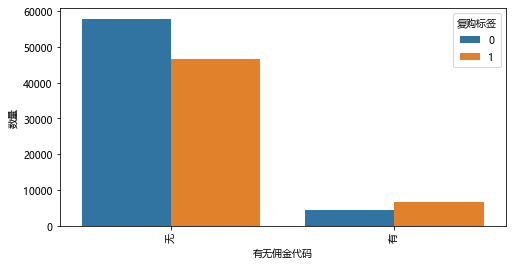

In [149]:
plt_img(df_user_repurchase,'有无佣金代码')

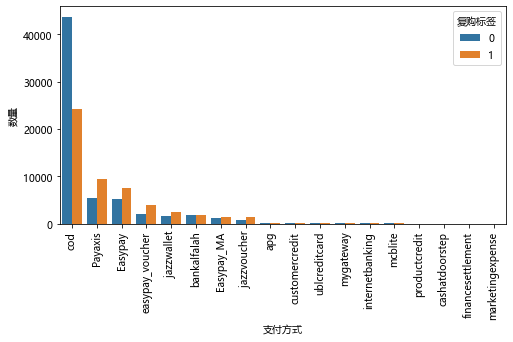

In [150]:
plt_img(df_user_repurchase,'支付方式')

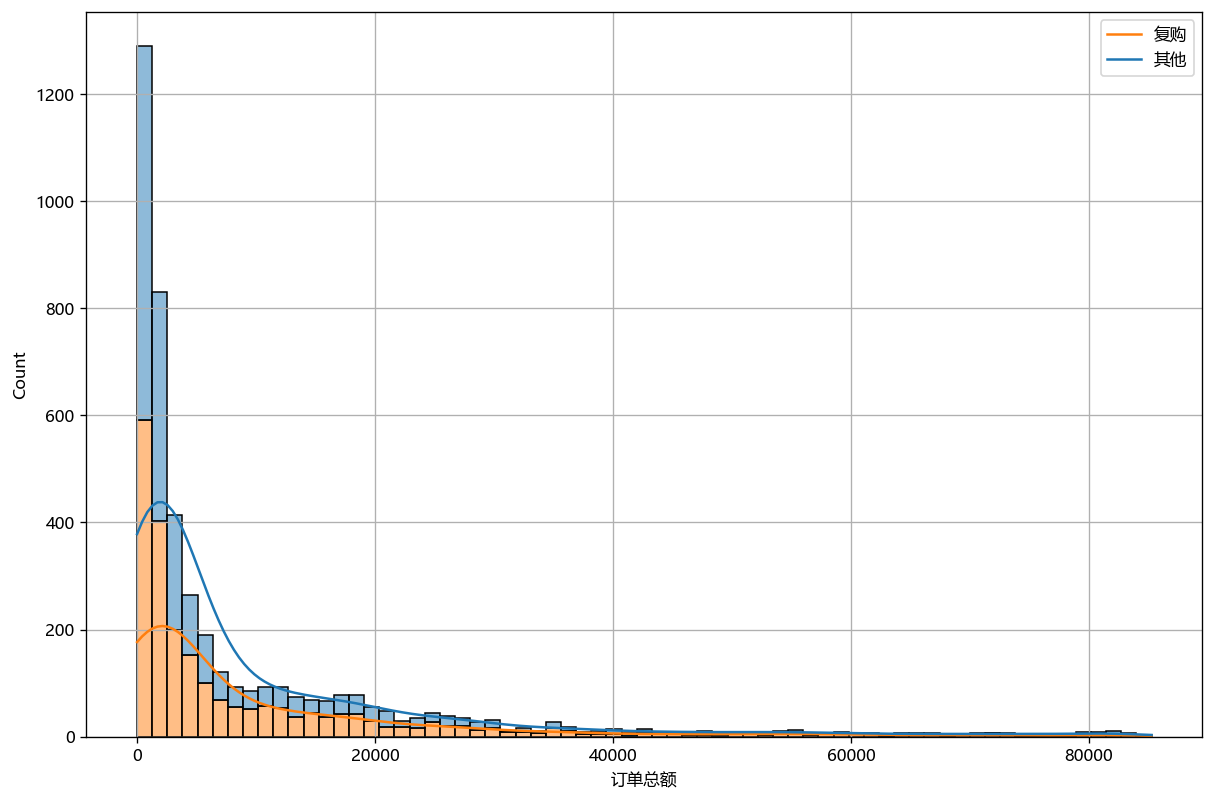

In [151]:
plt.figure(figsize=(12, 8), dpi=120)
df_user_repurchase_temp=df_user_repurchase[df_user_repurchase['订单总额']<85498]

temp = df_user_repurchase_temp.sample(10000)
temp = temp.groupby(['订单总额', '复购标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='订单总额', hue='复购标签', multiple='stack', kde=True)
plt.legend(labels=['复购', '其他'])
plt.grid()

In [152]:
df_user_repurchase.describe([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999,0.9999])

,复购标签,订单总额,首单购买总量,首单折扣金额,首单商品分类数量,首单SKU数量
count,115335.000000,115335.000000,115335.000000,115335.000000,115335.000000,115335.000000
mean,0.460277,7930.348175,1.747726,622.469862,1.101643,1.397720
std,0.498422,56253.426266,6.582828,3631.334074,0.399414,1.206544
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
10%,0.000000,440.000000,1.000000,0.000000,1.000000,1.000000
20%,0.000000,719.400000,1.000000,0.000000,1.000000,1.000000
30%,0.000000,999.000000,1.000000,0.000000,1.000000,1.000000
40%,0.000000,1199.000000,1.000000,0.000000,1.000000,1.000000
50%,0.000000,1700.000000,1.000000,0.000000,1.000000,1.000000
60%,1.000000,2563.344000,1.000000,0.000000,1.000000,1.000000


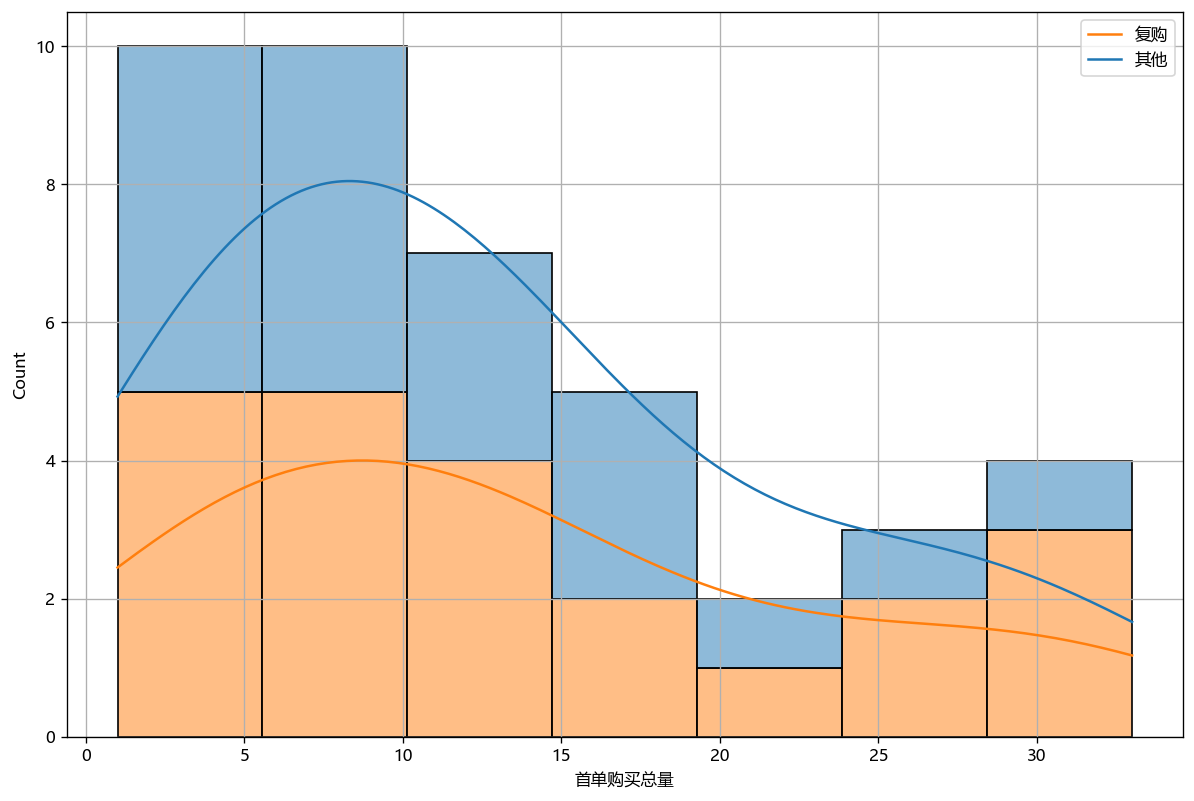

In [153]:
plt.figure(figsize=(12, 8), dpi=120)
df_user_repurchase_temp=df_user_repurchase[df_user_repurchase['首单购买总量']<41]

temp = df_user_repurchase_temp.sample(10000)
temp = temp.groupby(['首单购买总量', '复购标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='首单购买总量', hue='复购标签', multiple='stack', kde=True)
plt.legend(labels=['复购', '其他'])
plt.grid()

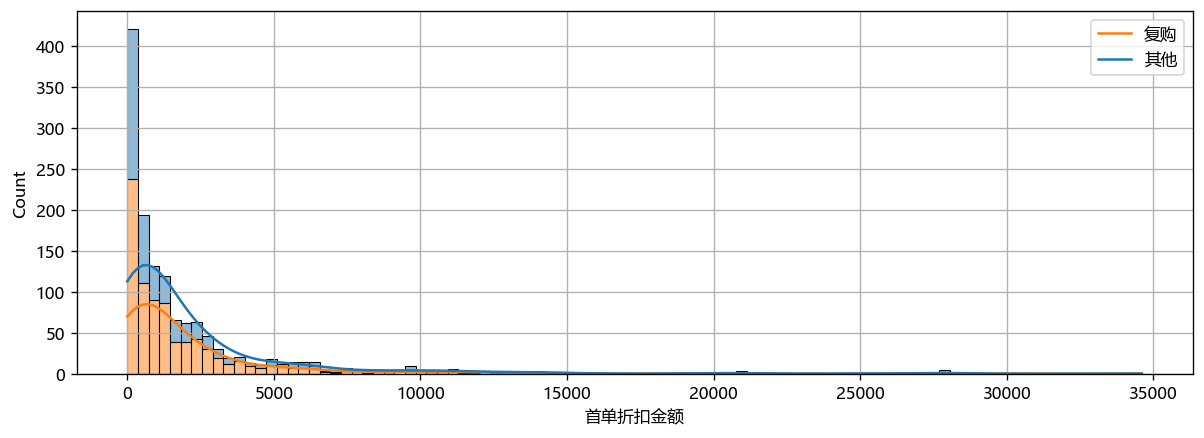

In [154]:
plt.figure(figsize=(12, 4), dpi=120)
df_user_repurchase_temp=df_user_repurchase[df_user_repurchase['首单折扣金额']<37690]

temp = df_user_repurchase_temp.sample(10000)
temp = temp.groupby(['首单折扣金额', '复购标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='首单折扣金额', hue='复购标签', multiple='stack', kde=True)
plt.legend(labels=['复购', '其他'])
plt.grid()

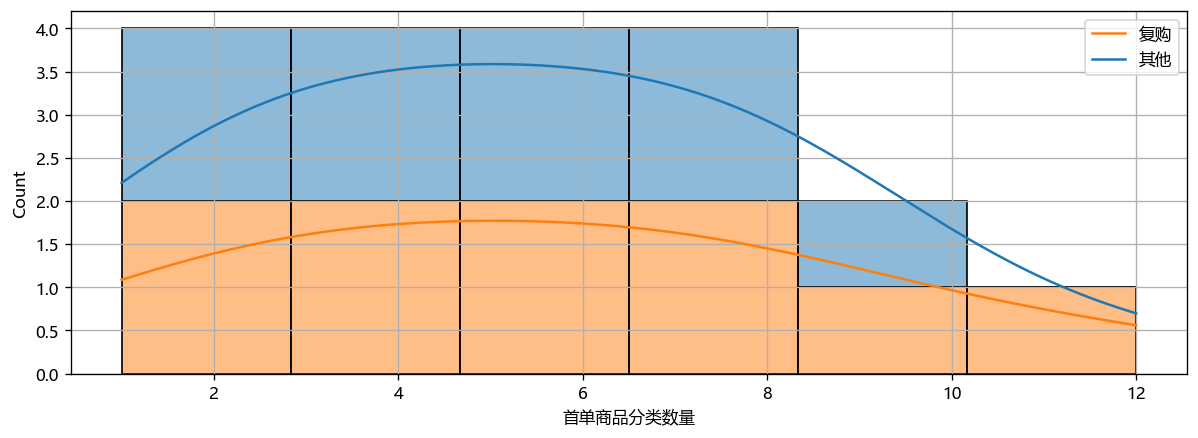

In [155]:
plt.figure(figsize=(12, 4), dpi=120)

temp = df_user_repurchase.groupby(['首单商品分类数量', '复购标签']).size().reset_index(name='数量')

sns.histplot(data=temp, x='首单商品分类数量', hue='复购标签', multiple='stack', kde=True)
plt.legend(labels=['复购', '其他'])
plt.grid()

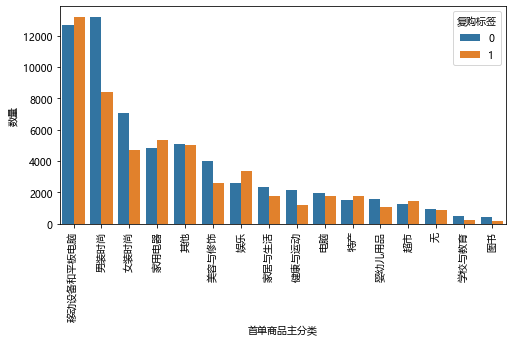

In [157]:
plt_img(df_user_repurchase,'首单商品主分类')

In [250]:
df_user_repurchase_predict = df_user_repurchase[['复购标签', '有无佣金代码', '客户注册时间', '支付方式',  '订单总额', 
       '首单购买总量', '首单折扣金额',  '首单商品主分类','首单SKU主分类','首单SKU数量']]


In [251]:
df_user_repurchase_predict.corr()

,复购标签,订单总额,首单购买总量,首单折扣金额,首单SKU数量
复购标签,1.000000,0.020883,0.009210,0.056260,0.032839
订单总额,0.020883,1.000000,0.842769,0.058854,-0.008712
首单购买总量,0.009210,0.842769,1.000000,0.048557,0.214161
首单折扣金额,0.056260,0.058854,0.048557,1.000000,0.218594
首单SKU数量,0.032839,-0.008712,0.214161,0.218594,1.000000


In [252]:
le = LabelEncoder()
sca = StandardScaler()
for i in df_user_repurchase_predict.columns:
    df_user_repurchase_predict[i] = le.fit_transform(df_user_repurchase_predict[i])

pred = df_user_repurchase_predict.copy()
pred1 = pred.drop('复购标签',axis=1)

df_user_repurchase_predict_model1 = df_user_repurchase_predict[df_user_repurchase_predict['复购标签']==0].sample(n=5000, random_state=1)
df_user_repurchase_predict_model2 = df_user_repurchase_predict[df_user_repurchase_predict['复购标签']==1].sample(n=5000, random_state=1)
df_user_repurchase_predict = pd.concat([df_user_repurchase_predict_model1,df_user_repurchase_predict_model2])
df_user_repurchase_predict = df_user_repurchase_predict.sample(frac=1).reset_index(drop=True)

X = df_user_repurchase_predict.drop('复购标签',axis=1)
y = df_user_repurchase_predict['复购标签']

X = sca.fit_transform(X)

train_x, test_x,train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [253]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    # 采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
        (model_name, model)
    ])
    model = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score='accuracy')
    best_model = model['best_model']
    print(best_model)

GridSearch 最优参数：{'decisiontreeclassifier__max_depth': 11}
GridSearch 最优分数：0.5149
准确率：0.5155,召回率：0.8740,精确度：0.5090, F1分数：0.6434
Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11, random_state=1))])
GridSearch 最优参数：{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
GridSearch 最优分数：0.5007
准确率：0.4980,召回率：0.9950,精确度：0.4990, F1分数：0.6647
Pipeline(steps=[('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=1, n_estimators=100,
                                    random_state=1))])
GridSearch 最优参数：{'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 400}
GridSearch 最优分数：0.6005
准确率：0.5970,召回率：0.6230,精确度：0.5922, F1分数：0.6072
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=3, n_estimators=400,
                                        random_state=1))])


In [268]:
model =  RandomForestClassifier(random_state=1,n_estimators=300,min_samples_split = 3)
model.fit(train_x,train_y)
pred2 = sca.fit_transform(pred1)
pred_prob = model.predict_proba(pred2)[:, 1]
threshold = 0.440

pred_adjusted = (pred_prob >= threshold).astype(int)
pred['预测'] = pred_adjusted # 原始数据集

In [269]:
print('所有数据的预测准确率是:',round((len(pred[pred['预测']==pred['复购标签']])) / 115335 *100,2),'%')
print(
        f'对原数据的试跑中\n实际为1的数量:{len(pred[pred["复购标签"]== 1])},'
        f'\n预测为1的数量:{len(pred[pred["预测"]== 1])},'
        f'\n实际为0的数量:{len(pred[pred["复购标签"]== 0])},'
        f'\n预测为0的数量:{len(pred[pred["预测"]== 0])},'
        f'\n预测为1准确的数量是:{len(pred[(pred["预测"]== 1)& (pred["复购标签"]== 1)])}'
        f'\n预测为0错误的数量是:{len(pred[(pred["预测"]== 0 )& (pred["复购标签"]== 1)])}'
        f'\n预测为0错误率是:{round(len(pred[(pred["预测"]== 0 )& (pred["复购标签"]== 1)]) / len(pred[pred["预测"]== 1]),2)}'
)

所有数据的预测准确率是: 59.68 %
对原数据的试跑中
实际为1的数量:53086,
预测为1的数量:76215,
实际为0的数量:62249,
预测为0的数量:39120,
预测为1准确的数量是:41398
预测为0错误的数量是:11688
预测为0错误率是:0.15


In [256]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

cr_train = classification_report(train_y, train_pred)
cr_test = classification_report(test_y, test_pred)

cm_train = confusion_matrix(train_y, train_pred)
cm_test = confusion_matrix(test_y, test_pred)

In [257]:
print('1. 训练分类报告 : \n')
print(cr_train)
print('\n\n2. 测试分类报告 : \n')
print(cr_test)

1. 训练分类报告 : 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4000
           1       0.95      0.95      0.95      4000

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



2. 测试分类报告 : 

              precision    recall  f1-score   support

           0       0.61      0.62      0.61      1000
           1       0.61      0.60      0.61      1000

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

